# ***Muziek classificeren***

|Teamleden|Kaggle Username|GitHub Username|
|--|--|--|
|Busse Heemskerk|bussejheemskerk|BJHeemskerk|
|Declan van den Hoek|declanvdh|DeclanvandenHoek|
|Isa Dijkstra|isadijkstra|IsaD01|

In dit notebook gaan we kleine muziek samples classificeren met behulp van unsupervised learning. Een deel van deze bestand heeft een genre label, terwijl de meeste dit niet zullen hebben. Aan ons is de taak om zo accuraat mogelijk te bepalen welke genres de unlabeled samples hebben, door middel van Unsupervised Learning.

Voor het project hebben we gewerkt in [GitHub](https://github.com/BJHeemskerk/MachineLearning/tree/main/Muziek), om makkelijk de bestanden te delen. Van elk model zijn de voorspellingen ook geupload naar [Kaggle](https://www.kaggle.com/competitions/muziek-genre-clustering/overview).

## **Inhoudsopgave** <a name='start'></a>
1. [Libaries en proef data inladen](#h1)
2. [Feature Engineering](#h2)
    1. [Spectrale Bandbreedte en Centroiden](#h2)
    1. [Tonnetz](#ton)
    1. [Spectrale Rolloff](#sroll)
    1. [Spectraal Contrast](#scon)
    1. [MFCC's](#mfcc)
    1. [Root Mean Square Energy](#rmsen)
    1. [Chroma Feature](#chroma)
    1. [Zero Crossing Rate](#zcr)
    1. [Tempo & Beat](#tenb)
    1. [Harmonie](#harm)
3. [Data Inladen](#h3)
4. [Clusteren](#h4)
    1. [Uitzoeken van Cluster Algoritme](#clus)
    2. [KMeans Clustering](#kmeans)
5. [Cluster Onderzoek](#h5)
    1. [Afstanden](#afstand)
    2. [Grafieken](#graf)
6. [PCA](#h6)
7. [NMF](#h7)
8. [Suggestie App](#h8)
9. [Conclusie & Discussie](#h9)
10. [Bronnenlijst](#Bron)

## **Libaries en proef data inladen** <a name='h1'></a>
Voordat we alle libaries kunnen inladen is het noodzakelijk dat de ipywidgets, pygame en tkinter libaries ook zijn geinstalleerd.

In [4]:
# Installeren van nodige libaries indien nog niet gedaan
# !pip install ipywidgets
# !pip install tkinder
# !pip install pygame

In [5]:
# Importeren standaard libaries voor bestand
import os
import librosa as lr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Importeren van FE libaries
from librosa.core import stft
from librosa.core import amplitude_to_db
import librosa.feature as lf
from librosa.feature import spectral_bandwidth, spectral_centroid
import IPython.display as ipd

# Om audio af te kunnen spelen
from IPython.display import Audio

# Importeren Clusteren
from sklearn.cluster import KMeans, Birch
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

# Importeren nodige libaries voor app
import random
import tkinter as tk
from tkinter import ttk
from pygame import mixer
import ipywidgets as widgets
from IPython.display import display, clear_output, HTML

pygame 2.5.2 (SDL 2.28.3, Python 3.11.4)
Hello from the pygame community. https://www.pygame.org/contribute.html


Na het inladen van alle nodige libaries kan er meteen gedoken worden in de features voor de dataset. Om deze features aan te kunnen maken wordt er eerst een enkele sample van geluid ingeladen om te testen of de code werkt.

In [6]:
# Kiezen van audio bestand
audiofile = "m00002.wav"

# Inladen met librosa
data, sfreq = lr.load(audiofile, sr=None)

# Omzetten naar np.array
audio_data = np.stack(data, axis=0)
sample_freqs = np.array(sfreq)

Nu het proef audio bestand is ingeladen kan er begonnen worden met het maken van features.

[Terug naar boven](#start)

# **Feature Engineering** <a name='h2'></a>

## **Spectrale Bandbreedte voor Geluid**
**Uitleg:**<br>
*Spectrale bandbreedte* voor geluid verwijst naar het bereik van frequenties in het geluidsspectrum. Het geeft aan hoe breed het frequentiebereik van een geluidssignaal is. Een bredere spectrale bandbreedte duidt op een geluid met diverse frequentiecomponenten, terwijl een smallere bandbreedte kan wijzen op een meer gefocust geluid.

**Formule:**<br>
De spectrale bandbreedte ($ \Delta f $) voor geluid kan worden berekend met de formule:<br>
$ \Delta f = f_{\text{hoge}} - f_{\text{lage}} $<br>
waarbij:
- $ f_{\text{hoge}} $ de frequentie van de hoogste aanwezige frequentie in het geluid is,
- $ f_{\text{lage}} $ de frequentie van de laagste aanwezige frequentie in het geluid is.

## **Spectrale Centroiden voor Geluid**
**Uitleg:**<br>
*Spectrale centroiden* voor geluid geven het gemiddelde aan van de frequenties in het geluidsspectrum. Het wordt gebruikt om het "zwaartepunt" van de spectrale inhoud van een geluidssignaal te bepalen.

**Formule:**<br>
De spectrale centroidfrequentie ($ f_c $) voor geluid kan worden berekend met de formule (Nam, 2001):<br>
$ f_c = \frac{\sum_{i=1}^{N} f_i \cdot A_i}{\sum_{i=1}^{N} A_i} $<br>
waarbij:
- $ N $ het aantal frequentiebanden is,
- $ f_i $ de frequentie is van het i-de frequentieband,
- $ A_i $ de amplitude is van het i-de frequentieband.


In [7]:
def calculate_spectrograms(audio_clips, n_fft=2048,
                           hop_length=512, win_length=None):
    """
    Bereken het spectrogram voor elk
    audiofragment in de audio_clips-reeks.

    Parameters:
    ----------
    audio_clips : lijst
        Een lijst met audioclips (numpy-arrays).
    n_fft : int, optioneel
        Het aantal datapunten dat wordt gebruikt
        in elk blok voor de FFT (standaard 2048).
    hop_length : int, optioneel
        Het aantal samples tussen opeenvolgende
        frames (standaard 512).
    win_length : int, optioneel
        De venstergrootte (standaard is `n_fft`).

    Returns:
    ----------
    spectrograms : lijst
        Een lijst met spectrogrammen die
        overeenkomen met elk audioclip.
    spec_db : array
        De spectrogrammen in decibels, voor het plotten.
    """
    spectrograms = []
    spectrograms_db = []

    for clip in audio_clips:

        # Berekenen van STFT
        stft_matrix = stft(y=clip,
                           n_fft=n_fft,
                           hop_length=hop_length,
                           win_length=win_length)

        # Absoluut maken matrix
        spectrogram = np.abs(stft_matrix)

        # Omzetten naar decibel
        spec_db = amplitude_to_db(S=spectrogram,
                                  ref=np.max)

        # Spectogram toevoegen aan lijst
        spectrograms.append(spectrogram)

        # spectogram decibels toevoegen aan lijst
        spectrograms_db.append(spec_db)

    return spectrograms, spectrograms_db


def calculate_spectral_features(spectrograms):
    """
    Bereken de centroid en bandbreedte
    voor elk spectrogram in een lijst.

    Parameters:
    ----------
    spectrograms : lijst
        Een lijst met spectrogrammen.

    Returns:
    ----------
    bandwidths : lijst
        Een lijst met bandbreedtes die
        overeenkomen met elk spectrogram.
    centroids : lijst
        Een lijst met centroids die
        overeenkomen met elk spectrogram.
    """
    bandwidths = []
    centroids = []

    for spectrogram in spectrograms:

        # Berekenen van spectrale bandbreedte
        spec_bw = spectral_bandwidth(S=spectrogram)

        # Berekenen van centroiden
        spec_cn = spectral_centroid(S=spectrogram)

        # Toevoegen van bandbreedtes aan lijst
        bandwidths.append(spec_bw)

        # Toevoegen van centroiden aan lijst
        centroids.append(spec_cn)

    return bandwidths, centroids

Nu gaan we kijken of de functies werken en of we de features kunnen extraheren uit de data.

In [8]:
# Maken van spectrogrammen
spectrograms, spectrograms_db = calculate_spectrograms([audio_data])

# Maken bandbreedtes en centroiden
bandwidths, centroids = calculate_spectral_features(spectrograms)

# Print de waarden
for i, (bw, cn) in enumerate(zip(bandwidths, centroids)):
    print(f"Clip {i + 1}: Bandwidth = {bw}\nCentroid = {cn}")

Clip 1: Bandwidth = [[1387.8015664  1786.23890171 2274.96903566 ... 2110.19401782
  2184.43996948 2396.59254929]]
Centroid = [[1198.24830323 1444.71127112 1984.44601624 ... 1503.10751554
  1631.59970002 1922.93583893]]


[Terug naar boven](#start)

## **Tonnetz** <a name='ton'></a>
**Uitleg:**<br>
De *Tonnetz* is een representatie van muzikale tonen in een driedimensionale ruimte. Het wordt vaak gebruikt voor de analyse van muzikale harmonie en modulatie. In het geval van een spectrogram wordt de Tonnetz meestal berekend op basis van een chromagram, afgeleid van het spectrogram.

**Formule:**<br>
Voor de tonnetz kon geen exacte formule worden gevonden. Het wordt in librosa berekent door chroma features te projecteren op een 6-dimensionale basis die de perfecte kwint, kleine terts en grote terts elk als tweedimensionale coördinaten voorstelt. (Librosa.Feature.Tonnetz — Librosa 0.10.1 Documentation, n.d.)


In [9]:
def calculate_tonnetz(data, sr):
    """
    Bereken de tonnetz-functies
    van het gegeven geluidssignaal.

    Parameters:
    ----------
    data : array
        Het geluidssignaal.
    sr : int
        De samplefrequentie van
        het geluidssignaal.

    Returns:
    ----------
    tonnetz : array
        Tonnetz-functies.
    """
    # Berekenen van tonnetz
    tonnetz = lf.tonnetz(y=data, sr=sr)

    return tonnetz

Om te testen of de tonnetz goed worden aangemaakt is er gekozen om een grafiek te tonen.

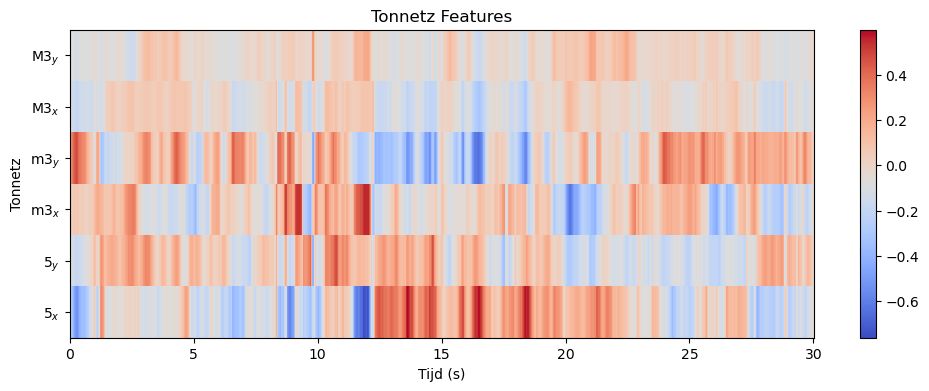

In [10]:
# Omzetten van sfreq naar floats
sample_freqs = float(sample_freqs)

# Maken Tonnetz
tonnetz = calculate_tonnetz(audio_data, sample_freqs)

# Plotten van de tonnetz
plt.figure(figsize=(12, 4))
lr.display.specshow(tonnetz, y_axis='tonnetz', x_axis='time')
plt.colorbar()
plt.title('Tonnetz Features')
plt.xlabel('Tijd (s)')
plt.show()

In de grafiek valt te welke waarde de tonnetz aanneemt door middel van de kleur. Hoe hoger het getal is, hoe beter de representatie is van harmonische relaties tussen de noten.

[Terug naar boven](#start)

## **Spectrale Rolloff**<a name='sroll'></a>
**Uitleg:**<br>
De *Spectrale Rolloff* is een maat voor de steilheid van het spectrum van een geluidssignaal. Het geeft aan welk percentage van de totale spectrale energie zich onder een bepaalde frequentie bevindt.

**Formule:**<br>
Voor spectrale rolloff was ook geen formule te vinden. Volgens de documentatie van Librosa vertegenwoordigt de spectrale rolloff specifiek de frequentie waarbij een bepaald percentage (aangegeven door 'roll_percent', default = 0.85) van de totale spectrale energie is geconcentreerd.


In [11]:
def calculate_spectral_rolloff(data, sr, roll_percent=0.85, n_fft=2048, hop_length=512):
    """
    Bereken de spectrale rolloff
    van het gegeven geluidssignaal.

    Parameters:
    ----------
    data : array
        Het geluidssignaal.
    sr : int
        De samplefrequentie van het geluidssignaal.
    roll_percent : float, optioneel
        Percentage van de spectrale energie waar
        de rolloff wordt berekend (standaard 0.85).
    n_fft : int, optioneel
        Grootte van het FFT-venster (standaard 2048).
    hop_length : int, optioneel
        Stapgrootte tussen raampunten (standaard 512).

    Returns:
    ----------
    spectral_rolloff : array
        Spectrale rolloff.
    """
    # Berekenen van Spectrale rolloff
    spectral_rolloff = lf.spectral_rolloff(
        y=data, sr=sr, roll_percent=roll_percent,
        n_fft=n_fft, hop_length=hop_length
        )

    return spectral_rolloff

Om te testen of de spectrale rolloff goed word aangemaakt is er gekozen om een grafiek te tonen.

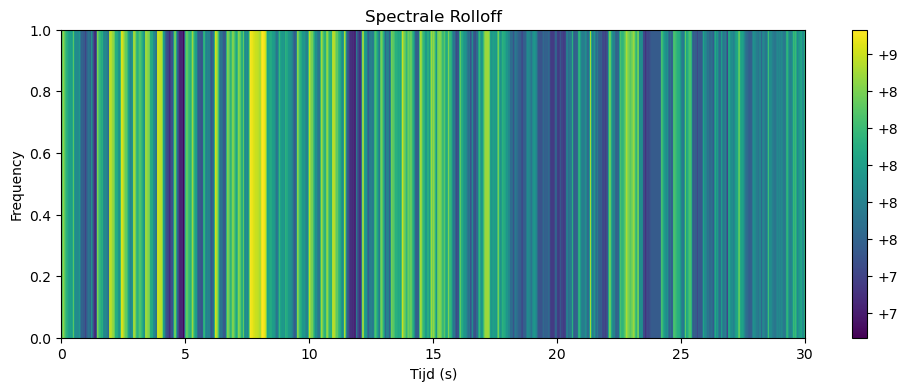

In [12]:
# Maken van de waarden
spectral_rolloff = calculate_spectral_rolloff(audio_data, sample_freqs)

# Plotten van Spectrale Rolloff
plt.figure(figsize=(12, 4))
plt.imshow(np.log1p(spectral_rolloff.reshape(1, -1)),
           cmap='viridis', aspect='auto', origin='lower',
           extent=[0, len(audio_data)/sample_freqs, 0, 1])

plt.colorbar(format='%+2.0f')
plt.title('Spectrale Rolloff')
plt.xlabel('Tijd (s)')
plt.ylabel('Frequency')
plt.show()

In de grafiek is te zien wanneer er een concentratie is van hogere frequenties en wanneer er lagere zijn. Hoe hoger het getal is, hoe meer genconcetreerd de audio is op hogere frequenties.

[Terug naar boven](#start)

## **Spectraal Contrast**<a name='scon'></a>
**Uitleg:**<br>
*Spectraal Contrast* is een maatstaf voor het verschil in amplitude tussen pieken en dalen in het geluidsspectrum. Het geeft informatie over de variabiliteit van de spectrale energie.

**Formule:**<br>
Spectraal Contrast ($ SC $) wordt berekend met de formule:<br>
$ SC = \frac{\text{Gemiddelde van de hoogste amplitudes}}{\text{Gemiddelde van de laagste amplitudes}} $<br>
waarbij de hoogste en laagste amplitudes worden genomen over specifieke frequentiebanden.


In [13]:
def calculate_spectral_contrast(data, sr, n_fft=2048, hop_length=512):
    """
    Bereken spectrale contrasten van het gegeven geluidssignaal.

    Parameters:
    ----------
    data : array
        Het geluidssignaal.
    sr : int
        De samplefrequentie van het geluidssignaal.
    n_fft : int, optioneel
        Grootte van het FFT-venster (standaard 2048).
    hop_length : int, optioneel
        Stapgrootte tussen raampunten (standaard 512).

    Returns:
    ----------
    spectral_contrast : array
        Spectrale contrasten.
    """
    # Berekenen spectrale contrast
    spectral_contrast = lf.spectral_contrast(
        y=data, sr=sr, n_fft=n_fft, hop_length=hop_length
        )

    return spectral_contrast


Om te testen of de spectrale contrast goed wordt aangemaakt is er gekozen om een grafiek te tonen.

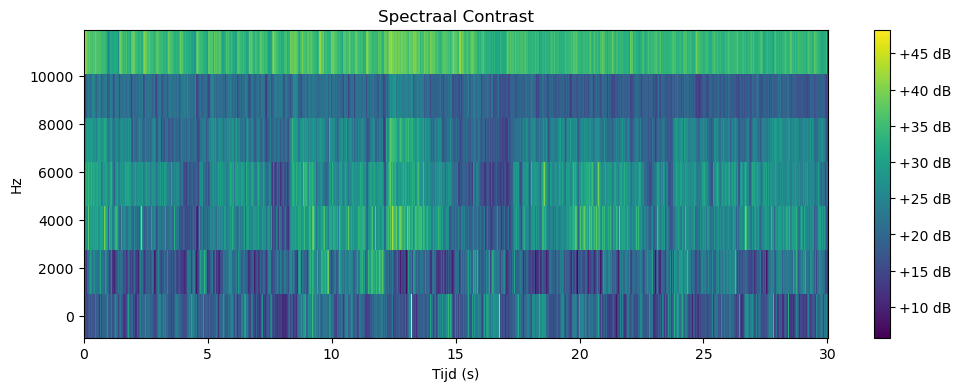

In [14]:
# Maken waarden spectraal contrast
spectral_contrast = calculate_spectral_contrast(audio_data, sample_freqs)

# Plotten spectraal contrast
plt.figure(figsize=(12, 4))
lr.display.specshow(spectral_contrast, sr=sample_freqs,
                         hop_length=512, x_axis='time',
                         y_axis='linear', cmap='viridis')

plt.colorbar(format='%+2.0f dB')
plt.title('Spectraal Contrast')
plt.xlabel('Tijd (s)')
plt.show()

Wat hier te zien is, zijn de verschillende niveaus aan contrast. Bij lagere waarden is er een meer evenredige verdeling van frequenties en energie.

[Terug naar boven](#start)

## **MFCC's**<a name='mfcc'></a>

Volgens Singh (2021) dienen Mel Frequency Cepstral Coefficients (MFCC's) als een representatie van het spectrum in een audio-signaal. Dit wordt bereikt door het signaal uit te drukken als een som van verschillende sinusgolven. In de onderstaande tekst wordt het process voor de MFCC uitgelegd, de wiskundige informatie is verkregen door gebruik van verschillende bronnen.

Het proces begint met het opdelen van het signaal in korte tijdsframes om veranderingen in frequentie vast te leggen. Dit wordt gedaan om ervoor te zorgen dat de eigenschappen van het geluid in de tijd goed worden weergegeven. Dit staat ook wel bekend als windowing.

   Wiskundige representatie windowing (Wikipedia, 2023):
   $ x(n) = x[n] \cdot w(n) $<br>
   Hierbij is:
   - $x(n)$ het oorspronkelijke signaal
   - $x[n]$ is het gevensterde signaal
   - $w(n)$ is de vensterfunctie.

Vervolgens wordt de Discrete Fourier Transformatie (DFT) toegepast. Dit houdt in dat op elk tijdsframe een FFT wordt uitgevoerd, wat resulteert in een frequentiespectrum. Hiermee krijgt men inzicht in de frequentiecomponenten van het geluid gedurende elk kort tijdsinterval.

   Wiskundige representatie van DFT (Discrete Fourier Transform | Brilliant Math & Science Wiki, n.d.): $ X_k = \sum_{n=0}^{N-1} x_n e^{-\frac{N}{2}\pi i k n} $<br>
   Hierbij is:
   - $X_k$ de DFT coëfficiënt
   - $k$ de frequentie-index
   - $N$ het aantal elementen van de reeks $x_n$
   - $x_n$ vertegenwoordigt de waarden van de reeks op discrete tijdsindices $n$
   - $e$ het natuurlijk logaritme
   - $i$ de imaginaire eenheid

Een volgende stap omvat het gebruik van Mel-gespreide Filterbanken. Deze filterbanken bestaan uit 20-40 driehoekige filters die op een specifieke manier over het frequentiespectrum zijn verdeeld. De filterbanken uiten zich wiskundig als een matrix. Vervolgens wordt elk tijdsframe vermenigvuldigd met de verkregen matrices, en de resulterende coëfficiënten worden opgeteld. Dit geeft een indicatie van de energie in verschillende frequentiebanden.

   Wiskundige representatie:
   $ C_m = \sum_{k=0}^{N-1} \log(|X(k)|) \cdot Filterbank $

Om de gegevens verder te verfijnen, worden logaritmes toegepast op de spectrogramwaarden. Dit resulteert in log-filterbankenergieën, waardoor de representatie van de audio-spectra meer overeenkomt met de menselijke perceptie van geluid.

   Wiskundige representatie:
   $ C_m' = \log(C_m) $

Dit proces resulteert in wat we Mel Frequency Cepstral Coefficients noemen. Deze coëfficiënten vormen een gestructureerde set getallen die een compacte representatie bieden van de spectrale kenmerken van het oorspronkelijke geluidssignaal. In python is het gelukkig mogelijk om deze stappen uit te laten voeren door middel van de librosa library.


In [15]:
def mfccs(data, sfreq):
    """
    Bereken Mel Frequency Cepstral Coefficients
    (MFCCs) voor het gegeven geluidssignaal.

    Parameters:
    ----------
    data : array
        Het geluidssignaal.

    sfreq : int
        De samplefrequentie van het geluidssignaal.

    Returns:
    ----------
    datadict : dict
        Een dictionary met gemiddelde waarden
        van MFCCs per coëfficiënt.
    """
    # Toepassen van mfcc via librosa
    mfcc = lr.feature.mfcc(y=data, sr=sfreq)
    datadict = {}

    # Vullen van datadict
    for var in range(len(mfcc)):
        datadict[f'mfcc{var + 1}_mean'] = np.mean(mfcc[var, :])

    return datadict

Om aan te tonen dat de MFCC goed worden gemaakt, tonen we het gemiddelde per MFCC waarde.

In [16]:
# Test mfccs function
mfcc_data = mfccs(audio_data, sample_freqs)

# Print the calculated MFCC mean values
for key, value in mfcc_data.items():
    print(f"{key}: {value}")

mfcc1_mean: -298.7561340332031
mfcc2_mean: 112.07627868652344
mfcc3_mean: 6.4888176918029785
mfcc4_mean: 28.389169692993164
mfcc5_mean: -6.770986557006836
mfcc6_mean: 16.645587921142578
mfcc7_mean: -11.807552337646484
mfcc8_mean: 12.744362831115723
mfcc9_mean: -8.340970993041992
mfcc10_mean: 13.89322280883789
mfcc11_mean: -4.237726211547852
mfcc12_mean: 2.317612886428833
mfcc13_mean: -4.329582214355469
mfcc14_mean: 1.404544472694397
mfcc15_mean: 0.7084854245185852
mfcc16_mean: 13.465459823608398
mfcc17_mean: 9.408201217651367
mfcc18_mean: 6.9103803634643555
mfcc19_mean: 7.880009174346924
mfcc20_mean: -1.778984785079956


[Terug naar boven](#start)

## **Root Mean Square energy**<a name='rmsen'></a>

De energie van muziek kan ook wel gedefinieerd worden als de intensiteit van de muziek. In praktische termen is dit de amplitude van de golf (?)(Ik breidt het wel uit en zoek er een bron bij)

Dit geeft ons een idee van de algemene intensiteit van een nummer. Theoretisch zou dit kunnen helpen met het onderscheiden tussen genres, een metal nummer zou over het algemeen intenser zijn dan een klassiek stuk. 

In [17]:
def rms_energy_features(data):
    # Compute RMS Energy
    rms_energy = lf.rms(y=data)

    return rms_energy

In [18]:
rms_energy_features(audio_data)

array([[0.0464538 , 0.05530685, 0.06490424, ..., 0.03972533, 0.0372781 ,
        0.03184398]], dtype=float32)

[Terug naar boven](#start)

## **Chroma Feature**<a name='chroma'></a>

In muziektermen is de chroma feature gerelateerd aan de 12 toon klassen. Hiermee kunnen we een indicatie geven van de toonhoogtes van een muziekfragment. Dit hebben we gekozen omdate verschillende genres muziek over het algemeen ook verschillende tonen gebruiken.

In [19]:
def chroma_features(data, sfreq):
    # Compute Chroma feature
    chroma = lf.chroma_stft(y=data, sr=sfreq)

    datadict = {}

    # Fill datadict
    for var in range(len(chroma)):
        datadict[f'chroma{var + 1}_mean'] = np.mean(chroma[var, :])

    return datadict

In [20]:
chroma_features(audio_data, sample_freqs)

{'chroma1_mean': 0.11765494,
 'chroma2_mean': 0.13391094,
 'chroma3_mean': 0.22048318,
 'chroma4_mean': 0.18841048,
 'chroma5_mean': 0.16817723,
 'chroma6_mean': 0.1936365,
 'chroma7_mean': 0.13062777,
 'chroma8_mean': 0.20394577,
 'chroma9_mean': 0.3643956,
 'chroma10_mean': 0.28758332,
 'chroma11_mean': 0.22447796,
 'chroma12_mean': 0.18569975}

[Terug naar boven](#start)

## **Zero Crossing Rate**<a name='zcr'></a>

De zero crossing rate houd in hoe vaak het (audio)signaal verandert van positief naar negatief of andersom. Hiermee is grofweg te zien hoeveel ruis er in een fragment zit. 

In [21]:
def zero_crossing_rate_features(data):
    # Compute Zero Crossing Rate (ZCR)
    zcr = lf.zero_crossing_rate(y=data)

    return zcr

In [22]:
zero_crossing_rate_features(audio_data)

array([[0.02978516, 0.05078125, 0.06152344, ..., 0.04199219, 0.04736328,
        0.04003906]])

[Terug naar boven](#start)

## **Tempo & Beat** <a name='tenb'></a>

Tempo in de muziek verwijst naar de snelheid waarmee een muziekstuk wordt gespeeld. Het tempo wordt vaak afgedrukt in beats per minute (BPM). Hoe hoger het getal, hoe sneller de muziek is. 
- https://tweedehands-gitaar.nl/muziektheorie/begrippen/tempo
- https://librosa.org/doc/main/generated/librosa.beat.beat_track.html

In [23]:
def calculate_beat(audio_clips, sfreq):
    """
    Calculate the spectrogram for each audio clip in the audio_clips array.

    Parameters:
    - audio_clips: A list of audio clips (numpy arrays).
    - n_fft: The number of data points used in each block for the FFT (default 2048).
    - hop_length: The number of samples between successive frames (default 512).
    - win_length: The window size (default is `n_fft`).

    Returns:
    - spectrograms: A list of spectrograms corresponding to each audio clip.
    - spec_db: The spectrograms in decibels, for plotting
    """
    
    beat = []
    temp = []

    for clip in audio_clips:

        tempo, beats = lr.beat.beat_track(y=clip, sr=sfreq)

        beat.append(beats)
        temp.append(tempo)
    
    return beat, temp

In [24]:
beats = calculate_beat([audio_data], sample_freqs)
beats

([array([   4,   23,   44,   64,   85,  106,  127,  148,  168,  188,  208,
          228,  249,  269,  289,  308,  329,  350,  370,  391,  411,  432,
          452,  472,  493,  514,  534,  555,  574,  593,  613,  633,  654,
          673,  694,  715,  736,  756,  777,  798,  819,  838,  859,  879,
          900,  920,  936,  952,  971,  992, 1013, 1033, 1054, 1075, 1096,
         1116, 1136, 1157, 1177, 1196, 1215, 1234, 1253, 1272])],
 [129.19921875])

[Terug naar boven](#start)

## **Harmonie** <a name='harm'></a>
Harmonie in de muziek betekent dat verschillende tonen op hetzelfde moment worden gespeeld of gezongen. Uit de functie krijg je een audio tijdserie die de harmonische elementen laat zien.

Harmonie in de muziek betekent dat verschillende tonen op hetzelfde moment worden gespeeld of gezongen. Met behulp van de librosa.effects.hpss(y) functie kun je de harmonische elementen van een audiogolfvorm verkrijgen door de resulterende harmonische component (H) te analyseren.

- https://librosa.org/doc/main/generated/librosa.effects.hpss.html
- http://www.hoorn.be/muziektermen.htm


In [25]:
def calculate_harmonie(audio_clips):
    """
    Calculate the spectrogram for each audio clip in the audio_clips array.

    Parameters:
    - audio_clips: A list of audio clips (numpy arrays).
    - n_fft: The number of data points used in each block for the FFT (default 2048).
    - hop_length: The number of samples between successive frames (default 512).
    - win_length: The window size (default is `n_fft`).

    Returns:
    - spectrograms: A list of spectrograms corresponding to each audio clip.
    - spec_db: The spectrograms in decibels, for plotting
    """

    harmonie = []

    for clip in audio_clips:

        harmonic, _ = lr.effects.hpss(y=clip)

        harmonie.append(harmonic)
        
    return harmonie

In [26]:
harmonie = calculate_harmonie([audio_data])
harmonie

[array([-0.01020616, -0.01360198, -0.00642921, ...,  0.0164299 ,
         0.02202647,  0.01959856], dtype=float32)]

Nu de functies en features zijn uitgelegd en opgezet, kan de data ingeladen worden samen met de features.

[Terug naar boven](#start)

# **Data Inladen** <a name='h3'></a>

Om soepel te zorgen dat we beide bronnen kunnen inladen is er gekozen om een functie te maken die het voor ons regelt.

In [105]:
# Load labeled data from CSV
labeled_data = pd.read_csv("labels_new.csv", sep=',')
labeled_data = labeled_data.sort_values('filename')

def load_music(directory):
    """
    Deze functie laad verschillende muziekbestanden in vanuit
    een directory. De muziekbestanden worden vervolgens in een
    dataframe gezet waarbij ook meerdere features worden
    aangemaakt op basis van de eerder gemaakte functies.

    Parameters:
    ----------
    directory : str
        De naam van de map met audio bestanden.

    Returns:
    ----------
    df : pandas.DataFrame
        Een pandas DataFrame met alle features en
        muziekbestanden uit de geselecteerde map.
    """
    # Aanmaken lists voor data
    audio_data = []
    sample_freqs = []
    mfcc_data = {}
    # chroma_data = {}

    # Lengte is 30 sec op 22050Hz
    lengte = 30 * 22050

    # Processen van audio bestanden
    for file in os.listdir(directory):
        if file.endswith(".wav"):
            file_path = os.path.join(directory, file)
            data, sfreq = lr.load(file_path, sr=None)

            # Aanpassen lengte bestand naar 30 sec
            if len(data) > lengte:
                data = data[:lengte]
            elif len(data) < lengte:
                padding = lengte - len(data)
                data = np.pad(data, (0, padding), mode='constant')

            # Toevoegen van de data en sample frequenties aan lijsten
            audio_data.append(data)
            sample_freqs.append(sfreq)

            # Aanmaken van de MFCC en de Chroma
            mfcc_dict = mfccs(data, sfreq)
            # chroma_dict = chroma_features(data, sfreq)

            # Updaten van dict met elke MFCC
            for key, value in mfcc_dict.items():
                if key not in mfcc_data:
                    mfcc_data[key] = []
                mfcc_data[key].append(value)

            # Updaten van dict met elke Chroma
            # for key, value in chroma_dict.items():
                # if key not in chroma_data:
                    # chroma_data[key] = []
                # chroma_data[key].append(value)

    # Omzetten van data en frequenties naar np.arrays
    audio_data = np.stack(audio_data, axis=0)
    sample_freqs = np.array(sample_freqs)

    # Maken van dataframe met huidige data
    df = pd.DataFrame({
        'filename': os.listdir(directory),
        'data': audio_data.tolist(),
        'Hz': sample_freqs.tolist(),
    })

    # Toevoegen van alle MFCC's
    for key, values in mfcc_data.items():
        df[key] = values
    
    # Toevoegen van alle Chroma's
    # for key, values in chroma_data.items():
        # df[key] = values

    # Labels mergen in data indien de directory labeled heet
    if directory == "labeled":
        df = labeled_data.merge(df, how='left', on='filename')

    # Berekenen van spectogrammen en features
    # Spectogrammen
    spectrograms, spectrograms_db = calculate_spectrograms(
        audio_data, n_fft=2048, hop_length=512, win_length=None
        )
    
    # Bandbreedte en Centroids
    bandwidths, centroids = calculate_spectral_features(
        spectrograms
        )
    
    # Spectrale contrast
    spectral_contrast = calculate_spectral_contrast(
        audio_data, sfreq, n_fft=2048, hop_length=512
        )
    
    # Tonnetz
    tonnetz = calculate_tonnetz(
        audio_data, sfreq
        )
    
    # Spectrale rolloff
    spectral_rolloff = calculate_spectral_rolloff(
        audio_data, sfreq, roll_percent=0.85, n_fft=2048, hop_length=512
        )
    
    # Root Mean Squared Enerdy
    rms = rms_energy_features(
        audio_data
        )
    
    # Zero Crossing Rate
    zcr = zero_crossing_rate_features(
        audio_data
        )
    
    # Beat en Tempo
    beat, tempo = calculate_beat(
        audio_data, sfreq
        )
    
    # Harmonie
    harmonie = calculate_harmonie(
        audio_data
        )

    # Toevoegen van alle features aan dataframe
    df['mean_bandwidth'] = [np.mean(arr) for arr in bandwidths]
    df['mean_centroids'] = [np.mean(arr) for arr in centroids]
    df['mean_spectral_contrast'] = [np.mean(arr) for arr in spectral_contrast]
    df['mean_tonnetz'] = [np.mean(arr) for arr in tonnetz]
    df['mean_spectral_rolloff'] = [np.mean(arr) for arr in spectral_rolloff]
    df['mean_rms_energy'] = [np.mean(arr) for arr in rms]
    df['mean_zcr'] = [np.mean(arr) for arr in zcr]
    df['mean_beat'] = [np.mean(arr) for arr in beat]
    df['mean_tempo'] = [np.mean(arr) for arr in tempo]
    df['mean_harmonie'] = [np.mean(arr) for arr in harmonie]

    # Tonen van dataframe met index = filename
    df = df.set_index('filename')
    display(df.head())

    return df

Zoals er te zien is de chroma functie veranderd in comments. Deze code is niet meer gebruikt, aangezien dit een klein probleempje opleverde bij het maken en bepalen van clusters. Door de feature niet in het dataframe te zetten is de loop van het clusteren duidelijker en logischer geworden.

Met behulp van de functie kunnen we nu beide datasets inladen in Python. Vervolgens worden deze in combinatie gebruikt om de clusters te bepalen en de genres van de clusters te kunnen definieren.

In [113]:
# Inladen van gelabelde dataset
labeled = load_music("labeled")

,genre,data,Hz,mfcc1_mean,mfcc2_mean,mfcc3_mean,mfcc4_mean,mfcc5_mean,mfcc6_mean,mfcc7_mean,...,mean_bandwidth,mean_centroids,mean_spectral_contrast,mean_tonnetz,mean_spectral_rolloff,mean_rms_energy,mean_zcr,mean_beat,mean_tempo,mean_harmonie
filename,,,,,,,,,,,,,,,,,,,,,
m00002.wav,jazz,"[-0.016357421875, -0.0228271484375, -0.0146789...",22050,-298.807953,112.078209,6.485770,28.386517,-6.764679,16.651894,-11.809684,...,1919.917650,1451.498371,24.225544,0.000351,3046.089914,0.050493,0.051222,642.500000,129.199219,0.000083
m00039.wav,reggae,"[-0.09478759765625, -0.15338134765625, -0.1439...",22050,-169.243668,110.447716,-8.553957,43.898693,0.266454,26.646509,-14.365674,...,2019.252686,1811.358216,22.132186,0.016613,3854.901690,0.123652,0.072178,623.820896,135.999178,-0.001899
m00041.wav,pop,"[0.078033447265625, -0.03765869140625, 0.12664...",22050,-18.854591,71.328522,-3.743232,-1.396592,0.710347,-1.049137,-1.052407,...,2992.192112,3111.061099,17.239507,-0.035761,6745.275879,0.198348,0.152910,616.652174,95.703125,0.000018
m00072.wav,disco,"[0.1060791015625, 0.0849609375, 0.062103271484...",22050,-69.599335,83.059570,-16.599524,0.119469,7.415704,0.769619,1.337008,...,2709.990169,2625.095044,19.452643,-0.018575,5606.407765,0.142975,0.120259,639.920635,129.199219,-0.000002
m00096.wav,disco,"[-0.03607177734375, -0.105682373046875, -0.201...",22050,-91.886307,87.604057,-2.058175,34.285538,-18.153370,19.344702,-14.697328,...,2486.020650,2550.135384,21.882917,0.009210,5585.291227,0.184435,0.115890,639.274194,123.046875,0.003067


In [106]:
# Inladen van de ongelabelde dataset
unlabeled = load_music("unlabeled")

,data,Hz,mfcc1_mean,mfcc2_mean,mfcc3_mean,mfcc4_mean,mfcc5_mean,mfcc6_mean,mfcc7_mean,mfcc8_mean,...,mean_bandwidth,mean_centroids,mean_spectral_contrast,mean_tonnetz,mean_spectral_rolloff,mean_rms_energy,mean_zcr,mean_beat,mean_tempo,mean_harmonie
filename,,,,,,,,,,,,,,,,,,,,,
m00003.wav,"[-0.129364013671875, -0.1422119140625, -0.1157...",22050,-82.501259,97.344116,-34.373585,71.405922,-3.283182,17.367373,-9.023832,16.011181,...,2070.908729,2254.451748,20.382411,0.005218,4381.173508,0.136249,0.120159,636.772727,135.999178,-0.001880
m00012.wav,"[-0.003814697265625, 0.089080810546875, 0.1600...",22050,-1.925411,72.695557,-32.789642,63.592033,-18.557953,25.872955,-13.854105,18.064384,...,2286.246872,2908.260266,20.043229,0.001804,5405.642313,0.217447,0.178119,612.180000,103.359375,0.000014
m00013.wav,"[0.004791259765625, 0.0048828125, 0.0045166015...",22050,-287.520996,101.737930,-35.368999,41.282764,-12.745123,17.284992,-13.978299,16.311886,...,1865.851544,1953.012399,23.257077,0.012233,3780.543806,0.029100,0.123492,639.305263,184.570312,-0.000730
m00043.wav,"[-0.11505126953125, -0.12127685546875, -0.1372...",22050,-120.127808,91.287666,-38.794960,75.003784,-3.806012,22.666491,-8.123723,23.654572,...,2073.302486,2384.812610,19.721734,0.014826,4585.038942,0.100442,0.126103,639.573529,135.999178,-0.000309
m00044.wav,"[-0.017822265625, -0.016693115234375, -0.01486...",22050,-437.525208,170.971405,7.386171,-3.108705,0.777302,-11.135056,-12.523807,-6.900928,...,899.979779,790.478225,20.256635,-0.024661,1159.401323,0.018844,0.052112,578.258065,143.554688,-0.000012


Nu de data is ingeladen kunnen we met behulp van de Audio functie een bestand afspelen in het notebook.

In [30]:
# Pick a random audio clip
random_filename = np.random.choice(labeled.index, size=1, replace=False).item()

# Access the data, Hz and genre
clip = np.array(labeled.at[random_filename, 'data'])
sfreq = labeled.at[random_filename, 'Hz']
genre = labeled.at[random_filename, 'genre']

# Tonen van bestandsnaam en het genre
print(f"Bestand en genre: {random_filename}, {genre}")

# Play the clip
Audio(data=clip, rate=sfreq)

Bestand en genre: m00716.wav, jazz


## **Clusteren** <a name='h4'></a>

Nu alle data is ingeladen en de features zijn aangemaakt, kunnen we richting het gebruik van unsupervised learning gaan. Er is namelijk een handeling die eerst nog zal moeten gebeuren, scaling. Scaling is van groot belang bij clustering algoritmes omdat alle data goed moet worden vergeleken met elkaar om clusters te kunnen vormen. Als alle data op andere schalen ligt, is het niet makkelijk om features te interpreteren en zal het model problemen ondervinden bij het maken van de clusters. Hiervoor zal een functie worden aangemaakt.

In [31]:
# Scalen van de data
def scaler(df):
    """
    Scaled de data in het dataframe op basis van de Z-score

    Parameters:
    ----------
    df : pandas.DataFrame
        Het dataframe waarvan de data moet worden gescaled

    Returns:
    ----------
    scaled_df : pandas.DataFrame
        Het dataframe nadat scaling is toegepast
    """
    # Berekenen van gemiddelde en standaard deviatie
    gem = df.mean(numeric_only=True)
    std = df.std(ddof=0, numeric_only=True)
    
    # Berekenen van de waardes in het dataframe
    scaled_df = (df - gem) / std

    return scaled_df

Nu de functie is gemaakt kunnen we deze toepassen op de data.

In [107]:
# Toepassen van scaler op unlabeled
scdf = scaler(unlabeled)

# Droppen van data en Hz kolommen omdat deze geen toepassing hebben
# voor Unsupervised learning
scdf = scdf.drop(['data', 'Hz'], axis=1)

# Tonen van de eerste vijf regels
display(scdf.head())

,mean_bandwidth,mean_beat,mean_centroids,mean_harmonie,mean_rms_energy,mean_spectral_contrast,mean_spectral_rolloff,mean_tempo,mean_tonnetz,mean_zcr,...,mfcc1_mean,mfcc20_mean,mfcc2_mean,mfcc3_mean,mfcc4_mean,mfcc5_mean,mfcc6_mean,mfcc7_mean,mfcc8_mean,mfcc9_mean
filename,,,,,,,,,,,,,,,,,,,,,
m00003.wav,-0.282118,0.101179,-0.118884,-1.781320,-0.005254,0.078336,-0.205532,0.387660,-0.332126,0.027061,...,0.484487,-0.564025,-0.044274,-0.953633,2.103414,-0.223317,0.781341,-0.632439,0.962736,-1.800265
m00012.wav,0.019216,-0.440457,0.616770,0.310657,0.947308,-0.083214,0.293430,-0.702430,-0.452162,1.407482,...,1.074915,2.264119,-0.669653,-0.886789,1.719003,-1.585550,1.483047,-1.130237,1.147159,-0.935620
m00013.wav,-0.569065,0.156956,-0.458058,-0.511490,-1.262254,1.447517,-0.498065,2.009818,-0.085519,0.106458,...,-1.017818,0.345629,0.067205,-0.995640,0.621481,-1.067151,0.774544,-1.143036,0.989746,-0.158202
m00043.wav,-0.278768,0.162864,0.027796,-0.046399,-0.425318,-0.236340,-0.106240,0.387660,0.005644,0.168636,...,0.208774,-1.208863,-0.197937,-1.140219,2.280413,-0.269944,1.218515,-0.539675,1.649282,-1.265518
m00044.wav,-1.920661,-1.187562,-1.766122,0.281819,-1.382571,0.018429,-1.774679,0.639996,-1.382611,-1.593567,...,-2.116991,-1.297411,1.823784,0.808667,-1.562392,0.138805,-1.570094,-0.993139,-1.095278,-0.188952


## **Uitzoeken van Cluster Algoritme** <a name='clus'></a>

Met de gescalede data is het mogelijk om te beginnen aan het clusterings process. Dit gebeurt door gebruik te maken van een clustering alogritme, om de keuze voor het algoritme te maken wordt de silhouette score van drie verschillende cluster algoritmes berekend. 

In [108]:
# Kmeans Silhouette
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(scdf)
kmeans_score = silhouette_score(scdf, kmeans_labels)

# Birch Silhouette
birch = Birch(n_clusters=3, threshold=0.01)
birch_labels = birch.fit_predict(scdf)
birch_score = silhouette_score(scdf, birch_labels)

# Guassian Mixture Silhouette
gmm = GaussianMixture(n_components=3, random_state=42)
gmm_labels = gmm.fit_predict(scdf)
gmm_score = silhouette_score(scdf, gmm_labels)

# Uitprinten Silhouette scores
print("KMeans Silhouette Score:", kmeans_score)
print("Birch Silhouette Score:", birch_score)
print("Gaussian Mixture Silhouette Score:", gmm_score)

KMeans Silhouette Score: 0.37254592040266094
Birch Silhouette Score: 0.36750634064214
Gaussian Mixture Silhouette Score: 0.2122367556689989


## **KMeans Clustering** <a name='kmeans'></a>

K-Means is een unsupervised learning algoritme dat veel gebruikt wordt om datapunten op basis van overeenkomsten binnen features te groeperen in verschillende clusters. Het algoritme doorloopt een iteratief process dat er als volgt uit ziet:

#### **Voorbeeld iteratief process:**<br>

Dit voorbeeld is opgesteld door de stappen te volgen uit het artikel geschreven door Sharma (2023). Hierbij zullen we gebruik maken van de volgende denkbeeldige dataset:

| Kip | Eieren dag 1 | Eieren dag 2 |
|------|-----|-----|
| A | 1 | 3 |
| B | 2 | 5 |
| C | 2 | 1 |
| D | 5 | 5 |
| E | 4 | 2 |
| F | 3 | 4 |
| G | 1 | 4 |
| H | 5 | 3 |

**Stap 1: Kiezen van het aantal clusters (K)**<br>
Voor dit voorbeeld nemen we een aantal clusters van 2.

**Stap 2: Initialisatie van de centroïden**<br>
We beginnen met een k aantal centroïden, in dit geval hebben we een k van 2. Als begin nemen we kippen A en E als centroïden.

**Stap 3: Toewijzing van gegevenspunten aan clusters**<br>
We berekenen de afstand van elk punt tot beide centra en wijzen de punten toe aan het dichtstbijzijnde cluster. Dit kan door middel van de afstands formules. In dit voorbeeld zullen we gebruik maken van de Euclidische afstand:

$Euclidisch = \sqrt{(x_2 - x_1)^2 + (y_2 - y_1)^2}$

Hierbij zal dag 1 de waarde van $x$ zijn en dag 2 de waarde van $y$.<br>
Dit geeft de volgende berekeningen voor centroïd A:<br>
$Kip A: \sqrt{(1 - 1)^2 + (3 - 3)^2} = \sqrt{0 + 0} = 0$<br>
$Kip B: \sqrt{(1 - 2)^2 + (3 - 5)^2} = \sqrt{1 + 4} = \sqrt{5}$<br>
$Kip C: \sqrt{(1 - 2)^2 + (3 - 1)^2} = \sqrt{1 + 4} = \sqrt{5}$<br>
$Kip D: \sqrt{(1 - 5)^2 + (3 - 5)^2} = \sqrt{16 + 4} = \sqrt{20}$<br>
$Kip E: \sqrt{(1 - 4)^2 + (3 - 2)^2} = \sqrt{9 + 1} = \sqrt{10}$<br>
$Kip F: \sqrt{(1 - 3)^2 + (3 - 4)^2} = \sqrt{4 + 1} = \sqrt{5}$<br>
$Kip G: \sqrt{(1 - 1)^2 + (3 - 4)^2} = \sqrt{0 + 1} = 1$<br>
$Kip H: \sqrt{(1 - 5)^2 + (3 - 3)^2} = \sqrt{16 + 0} = \sqrt{16}$

En de volgende berekeningen voor centroïd E:<br>
$Kip A: \sqrt{(4 - 1)^2 + (2 - 3)^2} = \sqrt{9 + 1} = \sqrt{10}$<br>
$Kip B: \sqrt{(4 - 2)^2 + (2 - 5)^2} = \sqrt{4 + 9} = \sqrt{13}$<br>
$Kip C: \sqrt{(4 - 2)^2 + (2 - 1)^2} = \sqrt{4 + 1} = \sqrt{5}$<br>
$Kip D: \sqrt{(4 - 5)^2 + (2 - 5)^2} = \sqrt{1 + 9} = \sqrt{10}$<br>
$Kip E: \sqrt{(4 - 4)^2 + (2 - 2)^2} = \sqrt{0 + 0} = 0$<br>
$Kip F: \sqrt{(4 - 3)^2 + (2 - 4)^2} = \sqrt{1 + 4} = \sqrt{5}$<br>
$Kip G: \sqrt{(4 - 1)^2 + (2 - 4)^2} = \sqrt{9 + 4} = \sqrt{13}$<br>
$Kip H: \sqrt{(4 - 5)^2 + (2 - 3)^2} = \sqrt{1 + 1} = \sqrt{2}$<br>

Nu de afstanden bepaald zijn, kunnen de kippen aan de twee clusters worden toegewezen:<br>
- Cluster 1: A, B, F, G
- Cluster 2: C, D, E, H

De kippen C en F zijn willekeurig toegewezen aan clusters omdat de afstand gelijk is.

**Stap 4: Berekenen van nieuwe centroïden**<br>
Vervolgens berekenen we de nieuwe centroïden. Deze worden berekend door het gemiddelde te nemen van de nieuwe clusters.

Centroïd 1:<br> 
Gemiddelde van A, B, F en G, dus $x = \frac{1 + 2 + 3 + 1}{4} = 1.75$ en $y = \frac{3 + 5 + 4 + 4}{4} = 4$<br>
De centroïd is dus $(1.75, 4)$

Centroïd 2:<br>
Gemiddelde van C, D, E en H, dus $x = \frac{2 + 5 + 4 + 5}{4} = 4$ en $y = \frac{1 + 5 + 2 + 3}{4} = 2.75$<br>
De centroïd is dus $(4, 2.75)$

**Stap 5: Herhaling**<br>
Na stap vier wordt het process van de afstanden herhaald totdat er geen significante verandering meer aan bod komt. In dit voorbeeld doe ik stappen 3 en 4 nog 1 keer, maar dan met gebruik van de Manhattan afstand:

$Manhattan = |x_2 - x_1| + |y_2 - y_1|$

**Iteratie 2: Manhattan Editie**<br>
**Stap 3: Toewijzing van gegevenspunten aan clusters**<br>
Het gebruik van de manhattan afstand leid tot de volgende berkeningen:<br>
Voor centroïd 1 (1.75, 4):<br>
$Kip A: |1.75 - 1| + |4 - 3| = 0.75 + 1 = 1.75$<br>
$Kip B: |1.75 - 2| + |4 - 5| = 0.25 + 1 = 1.25$<br>
$Kip C: |1.75 - 2| + |4 - 1| = 0.25 + 3 = 3.25$<br>
$Kip D: |1.75 - 5| + |4 - 5| = 3.25 + 1 = 4.25$<br>
$Kip E: |1.75 - 4| + |4 - 2| = 2.25 + 2 = 4.25$<br>
$Kip F: |1.75 - 3| + |4 - 4| = 1.25 + 0 = 1.25$<br>
$Kip G: |1.75 - 1| + |4 - 4| = 0.75 + 0 = 0.75$<br>
$Kip H: |1.75 - 5| + |4 - 3| = 3.25 + 1 = 4.25$

Voor centroïd 2 (4, 2.75):<br>
$Kip A: |4 - 1| + |2.75 - 3| = 3 + 0.25 = 3.25$<br>
$Kip B: |4 - 2| + |2.75 - 5| = 2 + 2.25 = 4.25$<br>
$Kip C: |4 - 2| + |2.75 - 1| = 2 + 1.75 = 3.75$<br>
$Kip D: |4 - 5| + |2.75 - 5| = 3 + 2.25 = 5.25$<br>
$Kip E: |4 - 4| + |2.75 - 2| = 0 + 0.75 = 0.75$<br>
$Kip F: |4 - 3| + |2.75 - 4| = 1 + 1.25 = 2.25$<br>
$Kip G: |4 - 1| + |2.75 - 4| = 3 + 1.25 = 4.25$<br>
$Kip H: |4 - 5| + |2.75 - 3| = 1 + 0.25 = 1.25$

Deze afstanden maken de volgende clusters:
- Cluster 1: A, B, C, D, F, G
- Cluster 2: E, H

**Stap 4: Berekenen van nieuwe centroïden**<br>
Vervolgens berekenen we de nieuwe centroïden. Deze worden berekend door het gemiddelde te nemen van de nieuwe clusters.

Centroïd 1:<br> 
Gemiddelde van A, B, C, D, F en G, dus $x = \frac{1 + 2 + 2 + 5 + 3 + 1}{6} = 2.33$ en $y = \frac{3 + 5 + 1 + 5 + 4 + 4}{6} = 3.66$<br>
De centroïd is dus $(2.33, 3.66)$

Centroïd 2:<br>
Gemiddelde van E en H, dus $x = \frac{4 + 5}{2} = 4.5$ en $y = \frac{2 + 3}{2} = 2.5$<br>
De centroïd is dus $(4.5, 2.5)$

Vervolgens word dit process dus herhaald totdat er geen significante veranderingen plaats vinden. Aangezien in deze iteratie 2 kippen van cluster zijn gewisseld worden de afstanden nog minstens 1 maal berekent. Als er door deze afstanden geen nieuwe veranderingen komen zullen de iteraties stoppen.

Nu het duidelijk is hoe dit wordt gedaan, is het tijd om een veel grotere dataset te gebruiken. Gelukkig hebben we hier hulp van python en kunnen we beginnen bij het begin. Het bepalen van het aantal clusters. Om dit te doen voor de dataset zullen we gebruik maken van de elleboog methode. Deze methode berekent de inertia van elke hoeveelheid clusters en aan de hand van een grafiek kan er dan afgelezen worden hoeveel clusters optimaal is. Dit kan doordat de datapunten een denkbeeldige arm gaan vormen, waarbij er een enkel duidelijk buigpunt in zit. Dit buigpunt (de elleboog) is dan het optimaal aantal clusters om te gebruiken. In python kan de inertia gemakkelijk worden bepaald door gebruik van de SKLearn libary. Hiermee kunnen we loopen over een stuk code, waarbij er voor een aangegeven range meerdere modellen worden gemaakt en de inertia van elk model wordt berekent. Deze kunnen we vervolgens plotten met matplotlib om een elleboog te maken.

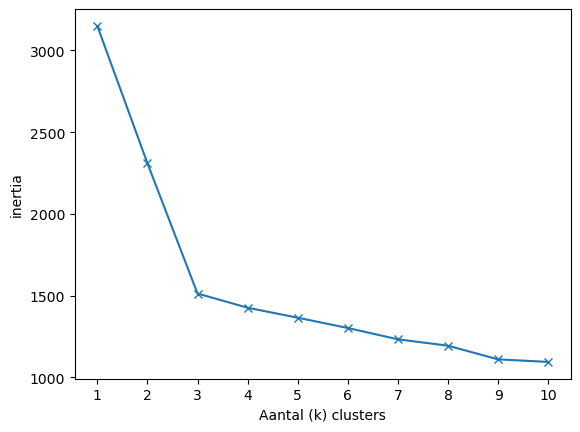

In [109]:
# Ignore the warning about KMeans memory leak
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn")

# Maken van inertia lijst en range voor k
inertia = []
k = range(1, 11)

# Loopen over het modelleren
for i in k:
    # Model aanmaken van K-Means
    model = KMeans(n_clusters=i, n_init=10)

    # Model fitten
    model.fit(scdf)

    # Intertia berekenen en toevoegen aan lijst
    inertia.append(model.inertia_)

# Plotten van de verschillende inertia
plt.plot(k, inertia, '-x')
plt.xlabel('Aantal (k) clusters')
plt.ylabel('inertia')
plt.xticks(k)
plt.show()

Zoals te zien is in de grafiek is het elleboog punt op k=3. Dit geeft aan dat het optimaal aantal cluster gelijk is aan 3. Minder clusters zal leiden tot een loss aan informatie, terwijl meer clusters zal leiden tot onduidelijke voorspellingen. Nu het aantal clusters bekent is kunnen we dit invoeren om een K-Means model te trainen en de clusters neer te zetten. Omdat deze handeling door het project heen vaker moet gaan gebeuren, is het in een functie gezet.

In [78]:
def clusteren(k, data):
    """
    Deze functie voert een KMeans Clustering
    uit op basis van k clusters.

    Parameters:
    ----------
    k : int
        Aantal clusters, van te voren bepaald
        met de elleboog methode

    data : pandas.DataFrame
        De data waarop je het algoritme toepast
    
    Returns:
    ----------
    df : pandas.DataFrame
        Het DataFrame waarop clustering is
        toegepast.
    """
    # Uitvoeren van K-Means om data te groeperen
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)

    # Clusters toevoegen aan dataframe
    data['cluster'] = kmeans.fit_predict(data)

    # Tonen van hoeveelheid in elk cluster
    print(data['cluster'].value_counts())

    return data

In [110]:
# Invoeren van aan clusters
k = 3

# Toepassen clusterings functie
scdf = clusteren(k, scdf)

1    40
0    39
2    26
Name: cluster, dtype: int64


In onze data zijn nu de drie clusters geplaatst. Zoals te zien is zijn er 40 audio fragmenten die horen bij cluster 0, 39 die horen bij cluster 2 en 26 die horen bij cluster 1.

[Terug naar boven](#start)

# **Cluster Onderzoek** <a name='h5'></a>

Nu de clusters zijn toegevoegd aan de data is het tijd om te bepalen welke cluster behoort to welke genre muziek. Om dit te doen, moeten we eerst de cluster en de genres groeperen op de respectieve groepen. Dit zorgt ervoor dat we de gemiddelde kenmerken van elke groep kunnen vergelijken om te vinden welke groepen bij elkaar horen. Voor de unlabeled dataset is dit gemakkelijk toe te passen.

In [119]:
# Groeperen van data per cluster
scdf_grouped = scdf.groupby('cluster').agg('mean')

# Tonen van het resultaat
display(scdf_grouped)

,mean_bandwidth,mean_beat,mean_centroids,mean_harmonie,mean_rms_energy,mean_spectral_contrast,mean_spectral_rolloff,mean_tempo,mean_tonnetz,mean_zcr,...,mfcc1_mean,mfcc20_mean,mfcc2_mean,mfcc3_mean,mfcc4_mean,mfcc5_mean,mfcc6_mean,mfcc7_mean,mfcc8_mean,mfcc9_mean
cluster,,,,,,,,,,,,,,,,,,,,,
0,-1.093588,0.025930,-1.127912,0.021940,-1.020845,0.922238,-1.128405,0.267355,0.595745,-0.963483,...,-1.127160,-0.201491,1.133648,-0.525976,-0.309505,-0.204740,-0.656909,-0.516017,-0.677724,-0.371118
1,1.072204,-0.025410,0.909882,0.218999,0.798669,-0.975278,0.982941,-0.374241,-0.345211,0.540537,...,0.657086,0.090581,-0.861932,1.011845,-0.672757,0.882764,-0.286639,1.031204,-0.292967,1.002006
2,-0.009162,0.000196,0.292050,-0.369831,0.302546,0.117071,0.180391,0.174722,-0.362524,0.613629,...,0.679839,0.162882,-0.374423,-0.767721,1.499267,-1.050988,1.426347,-0.812442,1.467305,-0.984872


Voor de labeled dataset is er iets meer werk dat moet worden gedaan. Dit komt voornamelijk omdat deze data nog niet is gescaled. De data zal dus eerst gescaled worden, vervolgens zullen de genres weer worden toegevoegd aan het gescalede dataframe. Daarna kan de data worden gegrouped.

In [120]:
# Scalen van labeled dataset
sc_label = scaler(labeled)

# Toevoegen genres aan scaled dataset
sc_label['genre'] = labeled['genre']

# Groeperen van de data op genre
scdfl = sc_label.groupby('genre').agg('mean', numeric_only=True)

# Droppen van de Hz kolom
scdfl = scdfl.drop('Hz', axis=1)

# Tonen van de resultaten
display(scdfl)

,mean_bandwidth,mean_beat,mean_centroids,mean_harmonie,mean_rms_energy,mean_spectral_contrast,mean_spectral_rolloff,mean_tempo,mean_tonnetz,mean_zcr,...,mfcc1_mean,mfcc20_mean,mfcc2_mean,mfcc3_mean,mfcc4_mean,mfcc5_mean,mfcc6_mean,mfcc7_mean,mfcc8_mean,mfcc9_mean
genre,,,,,,,,,,,,,,,,,,,,,
blues,-0.962848,-0.067569,-0.901665,0.326426,0.445559,0.491243,-0.862672,-1.568523,0.015649,-0.759994,...,-0.263798,-0.505011,0.918134,0.243213,0.556125,0.184839,0.188702,0.039634,0.233437,0.177360
classical,-1.283423,-1.396333,-1.115026,-0.151545,-1.175338,0.848172,-1.287750,0.401609,1.256835,-0.552573,...,-1.532584,1.323335,1.129616,-0.713336,-0.805599,0.187766,-1.129266,-0.087103,-1.427242,0.067154
country,-0.087529,-0.188934,-0.181292,0.338447,0.254206,0.524883,-0.166793,-0.069946,0.501087,-0.198584,...,0.264289,-0.454321,0.290693,0.339520,0.307473,-0.060878,-0.226583,-0.192221,-0.180159,-0.517528
disco,0.696171,0.171105,0.508099,0.960317,0.556157,-0.560642,0.576433,0.305484,-0.266149,0.148240,...,0.493680,-0.216592,-0.543266,0.305322,-0.784593,0.532762,-0.148738,0.742088,-0.372970,0.710443
hiphop,0.171094,0.449266,0.447543,0.283238,-0.100621,-0.186977,0.449276,0.129152,-0.219113,0.465422,...,0.408264,0.260917,-0.543491,-0.585650,0.695698,-0.667020,1.422759,-0.765019,1.277316,-0.152469
jazz,-0.560886,0.319686,-0.769580,0.170312,-0.766630,0.526863,-0.684459,-0.006439,0.159303,-0.851891,...,-0.712067,-0.385368,0.634218,0.095933,0.260028,-0.483867,-0.147716,-0.247177,-0.249819,0.062708
metal,-0.073127,0.353569,0.502345,-0.902857,0.065198,-0.244557,0.266441,1.010133,-0.346046,1.122383,...,0.711583,0.318826,-0.433773,-0.932222,1.311821,-1.029750,1.069734,-0.735267,1.189815,-0.881726
pop,1.455405,-0.034044,1.288320,-0.362690,1.224541,-1.145759,1.315076,-0.403529,-0.474510,0.880912,...,0.783727,-0.151191,-1.110466,0.967487,-1.477903,0.636546,-1.024685,0.956033,-0.852722,0.912750
reggae,0.423297,-0.033274,-0.009959,-0.757139,-0.396511,-0.484485,0.153553,0.137896,-0.393277,-0.536040,...,-0.476479,0.378747,-0.205455,0.606452,-0.312523,0.886485,-0.179706,0.637009,0.191636,0.335474


Nu de data volledig is gegroepeerd op cluster kan de data van beide datasets worden vergeleken met elkaar. Op deze wijze zullen we bepalen welke genres aanwezig zijn in de unlabeled dataset.

## **Afstanden** <a name='afstand'></a>

Om de eerste blik op de verschillende genres te werpen, berekenen we voor elke feature de kortste afstand tussen de clusters en de genres. Hierbij maken we gebruik van de volgende afstanden:

In [121]:
# Maken functie minkowski_afstand
def minkowski_afstand(x1, x2, p):
    """
    Deze functie berekent de afstand tussen twee punten door middel
    van de minkowski formule.

    Parameters:
    ----------
    x1 : numpy array of list
        Een set aan verschillende data punten

    x2 : numpy array of list
        Een set aan verschillende data punten

    p : int
        Parameter nodig voor de minkowski formule

    Returns:
    ----------
    minkowski : int or float
        De afstand tussen de punten volgens
        de minkowski formule
    """
    # Omzetten van eventuele losse varaibelen in een lijst
    if not isinstance(x1, (list, np.ndarray)):
        x1 = [x1]
    if not isinstance(x2, (list, np.ndarray)):
        x2 = [x2]

    # Berekenen van de afstand tussen de punten
    afstand = [abs(a - b) ** p for a, b in zip(x1, x2)]
    minkowski = sum(afstand) ** (1/p)
    return minkowski

# Maken functie manhattan_afstand
def manhattan_afstand(x1, x2):
    """
    Deze functie berekent de afstand tussen twee punten door middel
    van de manhattan formule.

    Parameters:
    ----------
    x1 : numpy array of list
        Een set aan verschillende data punten

    x2 : numpy array of list
        Een set aan verschillende data punten

    Returns:
    ----------
    manhattan : int or float
        De afstand tussen de punten volgens
        de manhattan formule
    """
    # Omzetten van eventuele losse varaibelen in een lijst
    if not isinstance(x1, (list, np.ndarray)):
        x1 = [x1]
    if not isinstance(x2, (list, np.ndarray)):
        x2 = [x2]

    # Berekenen van de afstand tussen de punten
    afstand = [abs(a - b) for a, b in zip(x1, x2)]
    manhattan = sum(afstand)

    return manhattan

# Maken functie euclidische_afstand
def euclidische_afstand(x1, x2):
    """
    Deze functie berekent de afstand tussen twee punten door middel
    van de euclidische formule.

    Parameters:
    ----------
    x1 : numpy array of list
        Een set aan verschillende data punten

    x2 : numpy array of list
        Een set aan verschillende data punten

    Returns:
    ----------
    euclidisch : int or float
        De afstand tussen de punten volgens
        de euclidische formule
    """
    # Omzetten van eventuele losse varaibelen in een lijst
    if not isinstance(x1, (list, np.ndarray)):
        x1 = [x1]
    if not isinstance(x2, (list, np.ndarray)):
        x2 = [x2]

    # Berekenen van de afstand tussen de punten
    afstand = [abs(a - b) for a, b in zip(x1, x2)]
    euclidisch = np.sqrt(sum(d ** 2 for d in afstand))

    return euclidisch

Nu de afstand functies zijn gemaakt is het mogelijk om de genres te bepalen door middel van de afstanden. Dit gaat als volgt in werking:
- Stap een is om per feature een leeg dataframe aan te maken waarbij de kolommen de genres zijn en de index gelijk is aan de clusters.
- Stap twee is om voor de huidige feature de afstand te berekenen voor elk cluster naar elk genre. Dit levert dus 10 afstanden op per cluster.
- Stap drie is om de kleinste afstand te selecteren tussen deze 10 afstanden, en het corresponderende genre op te slaan.
- Stap vier is om te kijken welk genre het meeste voorkomt tussen de afstanden. Ook wordt het tweede genre bekeken.
- Stap vijf is om de resultaten te tonen.

Omdat dit drie keer moet gebeuren is er een functie gemaakt om dit uit te voeren.

In [123]:
from collections import Counter

def bepaal_genres(data, afstand_func, *args):
    """
    Deze functie neemt een afstandsfunctie en bepaald de afstand van
    genre naar cluster. Dit gebeurt voor alle clusters en alle genres,
    het uiteindelijke antwoord is de meest voorkomende genre voor elk
    cluster.

    Parameters:
    ----------
    afstand_functie : func
        De afstands functie waarmee de afstand word berekend.

    Returns:
    ----------
    De meest voorkomende genre (de meeste kleine afstanden) per cluster
    """
    # Aanmaken dictionaries
    afstand_dfs = {}
    afstand = {}
    antwoorden = {}

    # Stap 1
    # For loop om dataframes te maken met afstanden
    for col in data.columns:
        # Aanmaken dataframe voor kolom met genres en clusters als index en kolom
        df_afstand = pd.DataFrame(index=data.index, columns=scdfl.index)
        # Stap 2
        for x, row1 in data.iterrows():
            for y, row2 in scdfl.iterrows():
                if args:
                    # Voor afstands functies met extra argumenten
                    df_afstand.at[x, y] = afstand_func(row1[col], row2[col], *args)
                else:
                    # Voor afstands functies met alleen a en b
                    df_afstand.at[x, y] = afstand_func(row1[col], row2[col])
        # Vullen van dict met feature afstanden
        afstand_dfs[col] = df_afstand

    # Stap 3
    # For loop voor kiezen juiste afstand
    for _, df_afstand in afstand_dfs.items():
        for i, row in df_afstand.iterrows():
            # Vinden van genre met kleinste afstand
            min_genre = min(row.items(), key=lambda x: x[1])[0]
            # Aanmaken key voor values als deze nog niet bestaat
            if i not in afstand:
                afstand[i] = []
            # Toevoegen kleinste genre afstand
            afstand[i].append(min_genre)

    # Stap 4
    # For loop om meest voorkomende en op één na meest voorkomende genre te vinden
    for key, value in afstand.items():
        # Vinden van meest voorkomende en op één na meest voorkomende genres en tellen
        genre_1, aantal_1 = Counter(value).most_common(1)[0]
        genre_2, aantal_2 = Counter(value).most_common(2)[1]

        # Maken resultaten dict
        antwoorden[key] = {
            'Genre 1': genre_1,
            'Aantal 1': aantal_1,
            'Genre 2': genre_2,
            'Aantal 2': aantal_2
        }

    # Stap 5
    # Printen van de uitkomsten per cluster
    print(f"\nGenres volgens {afstand_func.__name__}:")
    for key, value in antwoorden.items():
        print(f"Cluster {key}: {value}")

    return afstand_dfs


# Kijken welke clusters tot welke genre horen
df_euclidisch = bepaal_genres(scdf_grouped, euclidische_afstand)
df_manhattan = bepaal_genres(scdf_grouped, manhattan_afstand)
df_minkowski = bepaal_genres(scdf_grouped, minkowski_afstand, 2)


Genres volgens euclidische_afstand:
Cluster 0: {'Genre 1': 'classical', 'Aantal 1': 6, 'Genre 2': 'reggae', 'Aantal 2': 4}
Cluster 1: {'Genre 1': 'pop', 'Aantal 1': 10, 'Genre 2': 'disco', 'Aantal 2': 7}
Cluster 2: {'Genre 1': 'metal', 'Aantal 1': 12, 'Genre 2': 'hiphop', 'Aantal 2': 9}

Genres volgens manhattan_afstand:
Cluster 0: {'Genre 1': 'classical', 'Aantal 1': 6, 'Genre 2': 'reggae', 'Aantal 2': 4}
Cluster 1: {'Genre 1': 'pop', 'Aantal 1': 10, 'Genre 2': 'disco', 'Aantal 2': 7}
Cluster 2: {'Genre 1': 'metal', 'Aantal 1': 12, 'Genre 2': 'hiphop', 'Aantal 2': 9}

Genres volgens minkowski_afstand:
Cluster 0: {'Genre 1': 'classical', 'Aantal 1': 6, 'Genre 2': 'reggae', 'Aantal 2': 4}
Cluster 1: {'Genre 1': 'pop', 'Aantal 1': 10, 'Genre 2': 'disco', 'Aantal 2': 7}
Cluster 2: {'Genre 1': 'metal', 'Aantal 1': 12, 'Genre 2': 'hiphop', 'Aantal 2': 9}


Zoals er te zien is in de resultaten, zijn voor elke afstand dezelfde antwoorden gevonden. Deze resultaten leiden tot de volgende conclusies:
- Cluster 0 is waarschijnlijk klassieke muziek
- Cluster 1 is waarschijnlijk pop
- Cluster 2 is waarschijnlijk metal

[Terug naar boven](#start)

## **Grafieken** <a name='graf'></a>

Om een beter begrip te krijgen over welke clusters bij welke genres horen gaan we gebruik maken van scatterplots. In deze scatterplots zou het te zien moeten zijn welke factoren overlappen het meest met elkaar overlappen. Dit moet voornamelijk gebeuren voor clusters 0 en 1, cluster 2 is er waarschijnlijk zo uit te halen. Om dit toch met zekerheid te kunnen bevestigen zullen we beginnen met cluster 2. Omdat dit proces meerdere malen herhaald zal moeten worden maken we gebruik van een functie.

In [124]:
def vergelijking_genres(data1, data2, x, y):
    """
    Deze functie maakt twee scatterplots met de datapunten
    van aangegeven clusters en/of genres.

    Parameters:
    ----------
    data1 : pandas.DataFrame
        De data uit scdf

    data2 : pandas.DataFrame
        De data uit sc_label

    x : str
        De kolomnaam van feature 1

    y : str
        De kolomnaam van feature 2
    """
    # Maken van de plotsize
    plt.figure(figsize=(15, 6))

    # Maken eerste scatterplot
    sns.scatterplot(data=data1,
                    x=x,
                    y=y,
                    hue='cluster',
                    palette=['grey'] * len(data1['cluster'].unique()))
    
    # Maken tweede scatterplot
    sns.scatterplot(data=data2,
                    x=x,
                    y=y,
                    hue='genre')
    plt.show()

De eerste vergelijkingen van features die we gaan bekijken is tussen de tempo en de bandbreedte.

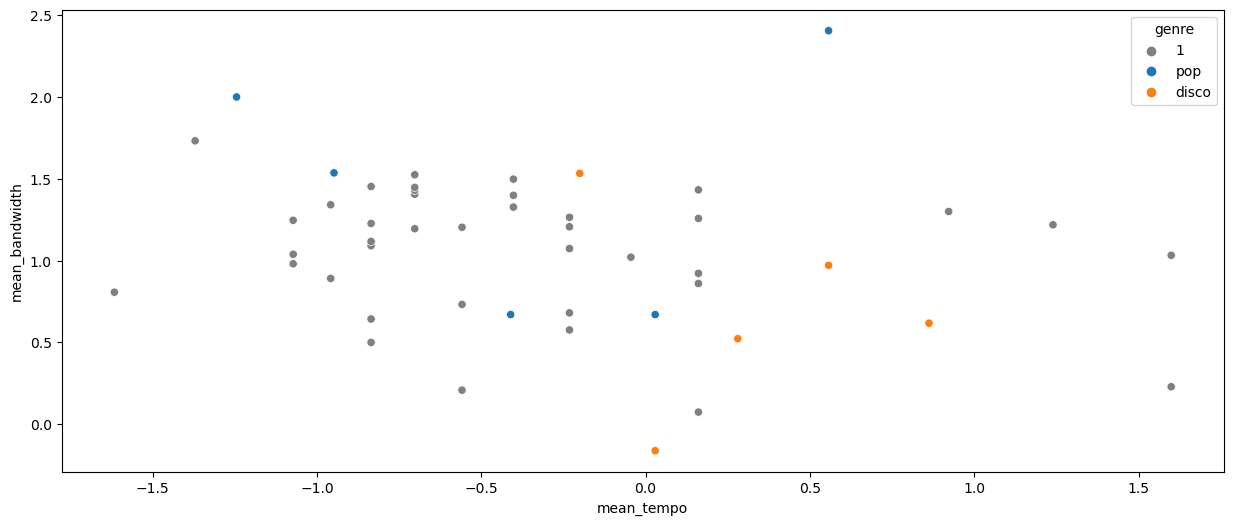

In [125]:
# Invoeren welke clusters er getoond moeten worden
clusters = [1]

# Invoeren welke genres er getoond moeten worden
genres = ['pop', 'disco']

# Invoeren van databronnen en kolommen voor de assen
data1 = scdf[scdf['cluster'].isin(clusters)]
data2 = sc_label[sc_label['genre'].isin(genres)]
x = 'mean_tempo'
y = 'mean_bandwidth'

# Uitvoeren van vergelijking
vergelijking_genres(
    data1=data1,
    data2=data2,
    x=x,
    y=y
)

Zoals er te zien is overlappen de genres van pop en disco niet goed. De cluster zit voornamelijk in het gedeelte van pop, dus is het goed aan te nemen dat pop het algemene genre is van cluster 2.

Nu zal er gekeken worden naar cluster 0. Hiervoor zullen dezelfde assen worden gebruikt, om deze reden worden x en y niet opnieuw gedefineerd.

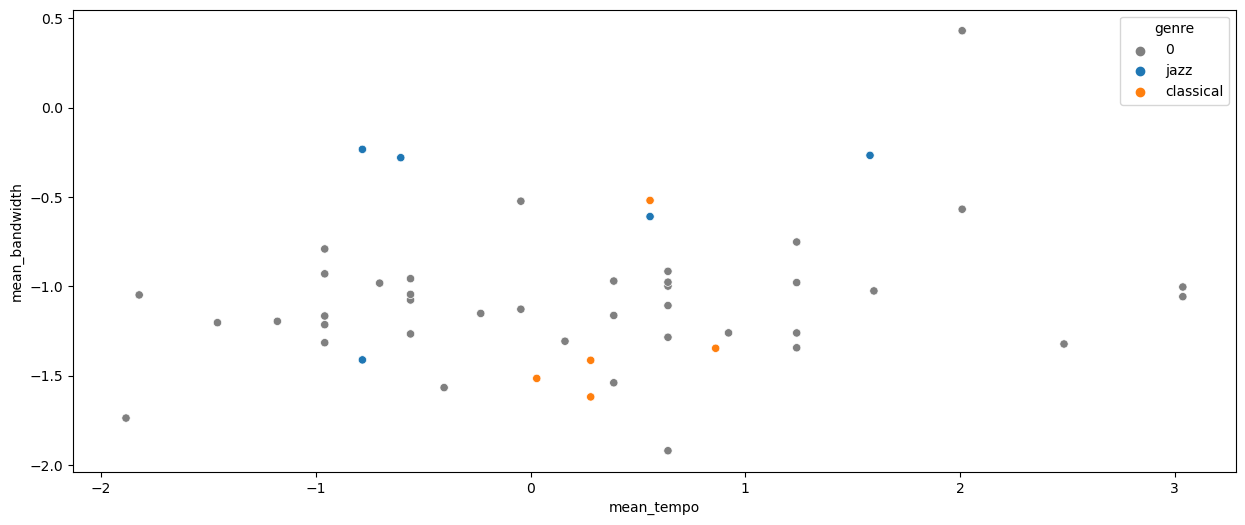

In [126]:
# Invoeren welke clusters er getoond moeten worden
clusters = [0]

# Invoeren welke genres er getoond moeten worden
genres = ['classical', 'jazz']

# Invoeren van databronnen en kolommen voor de assen
data1 = scdf[scdf['cluster'].isin(clusters)]
data2 = sc_label[sc_label['genre'].isin(genres)]

# Uitvoeren van vergelijking
vergelijking_genres(
    data1=data1,
    data2=data2,
    x=x,
    y=y
)

Zoals er te zien is, is het genre jazz uitgespreid over de gehele grafiek. Het genre classical is echter gefocussed rond het midden van cluster 0. Om deze reden is het aan te nemen dat classical waarschijnlijker is dan jazz.

Nu gaan we over naar de moeilijkste vergelijking, cluster 1. Met het minste aantal waarden dat onder dit cluster is gezien en met twee gelijke afstanden voor genres, is het niet zo makkelijk aan te nemen als bij de andere clusters.

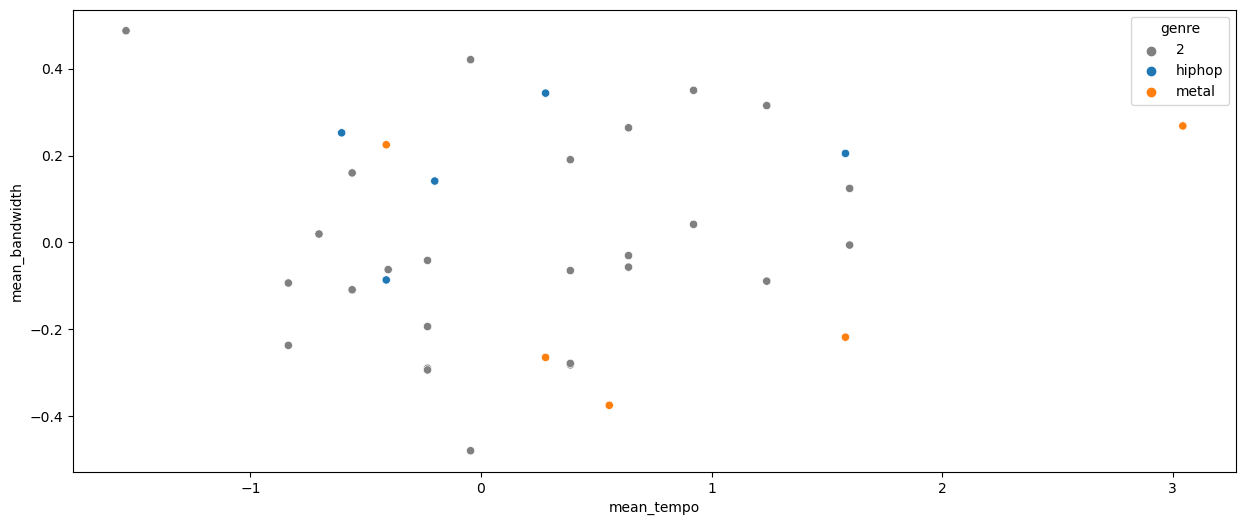

In [127]:
# Invoeren welke clusters er getoond moeten worden
clusters = [2]

# Invoeren welke genres er getoond moeten worden
genres = ['hiphop', 'metal']

# Invoeren van databronnen en kolommen voor de assen
data1 = scdf[scdf['cluster'].isin(clusters)]
data2 = sc_label[sc_label['genre'].isin(genres)]

# Uitvoeren van vergelijking
vergelijking_genres(
    data1=data1,
    data2=data2,
    x=x,
    y=y
)

Bij deze grafiek zie je niet heel veel. Het enige dat opvalt is dat metal een uitschieter buiten het cluster heeft. Om verder onderzoek te doen nemen we een kijkje bij andere features, totdat we een duidelijke conclusie kunnen trekken.

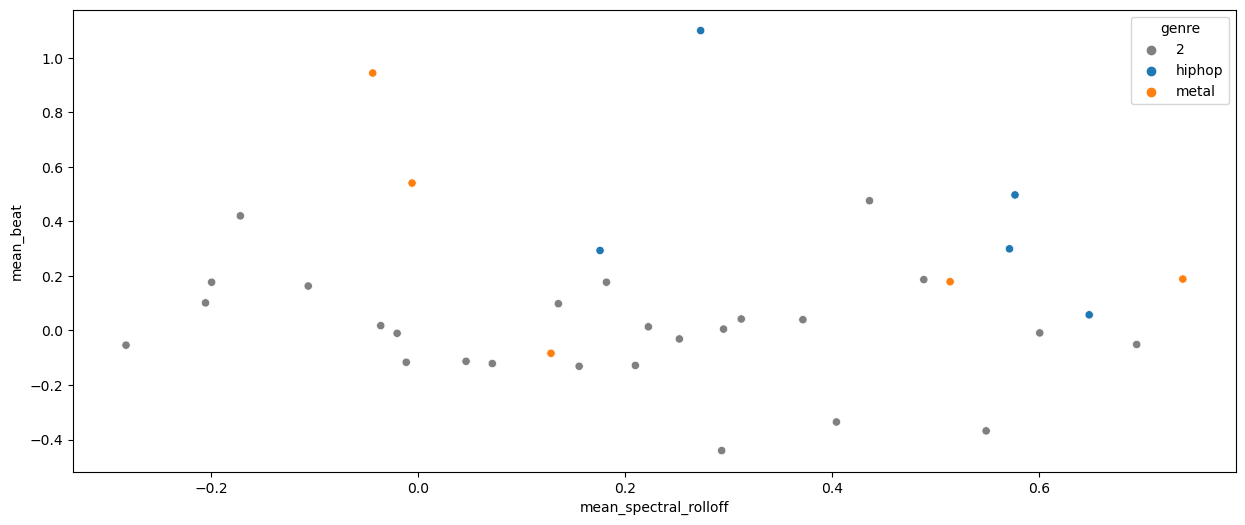

In [128]:
# Invoeren van nieuwe x en y
x = 'mean_spectral_rolloff'
y = 'mean_beat'

# Uitvoeren van vergelijking
vergelijking_genres(
    data1=data1,
    data2=data2,
    x=x,
    y=y
)

Bij deze grafiek zie je dat hiphop meer aan de linker kant ligt van het cluster, terwijl metal wat meer over het cluster is verdeeld.

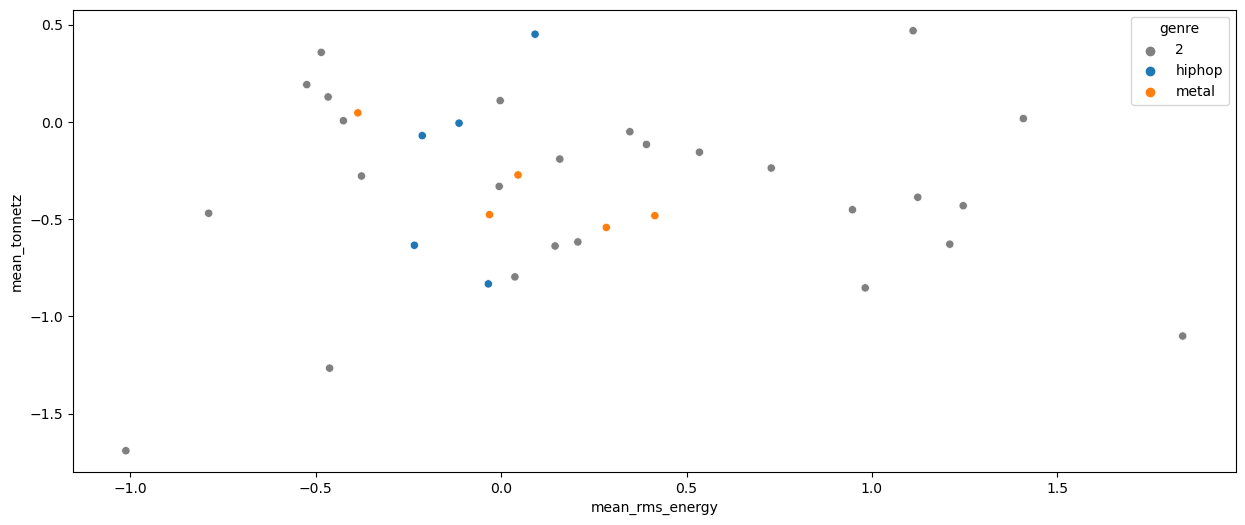

In [129]:
# Invoeren van nieuwe x en y
x = 'mean_rms_energy'
y = 'mean_tonnetz'

# Uitvoeren van vergelijking
vergelijking_genres(
    data1=data1,
    data2=data2,
    x=x,
    y=y
)

Bij deze grafiek zit hiphop ook iets meer naar de buitenkant van het cluster toe, terwijl metal wat meer in de kern van het cluster is.

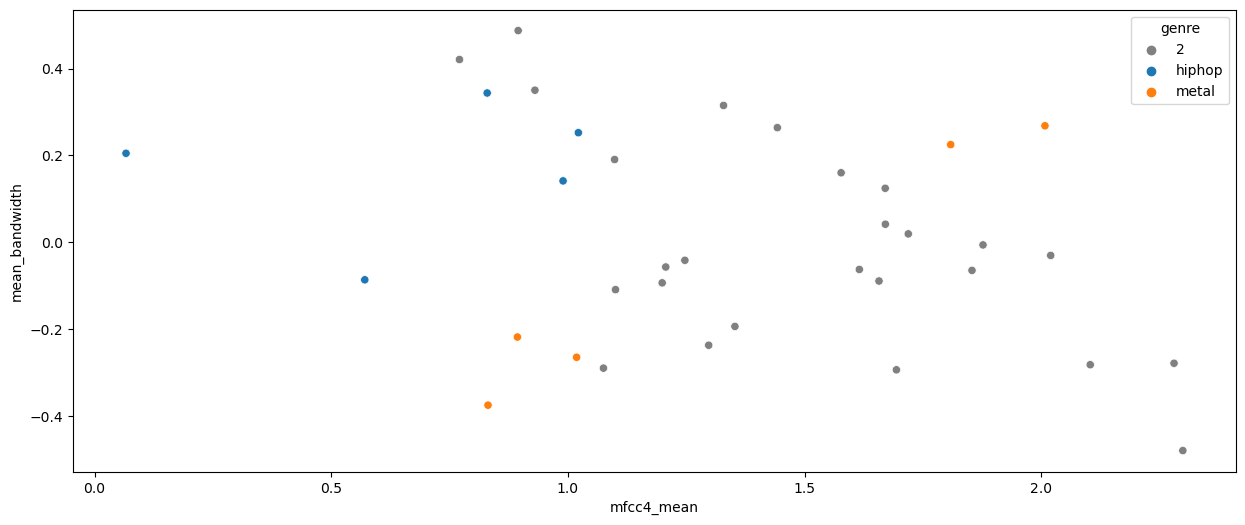

In [130]:
# Invoeren van nieuwe x en y
x = 'mfcc4_mean'
y = 'mean_bandwidth'

# Uitvoeren van vergelijking
vergelijking_genres(
    data1=data1,
    data2=data2,
    x=x,
    y=y
)

Bij de verdeling over de chorma_8 en de mfcc_4 is de verdeling ook meer geneigd naar metal toe. Tot nu toe leid het onderzoek wel iets meer naar metal. We zullen ze allebei gaan proberen op Kaggle en omdat metal voor nu onze keuze wordt doen we deze als tweede. Dit zorgt ervoor dat we hoe dan ook allebei de genres uitproberen. Om tot de upload te komen moet er eerste een map aangemaakt waarmee de cluster vervangen kunnen worden. Deze map is in de vorm van een dictionary. Na het aanmaken van de map zal er gebruik worden gemaakt van een fucntie om de waarden in het juiste format te zetten voor Kaggle.

In [131]:
def kaggle_upload(data, cluster_map, naam_csv):
    """
    Deze functie maakt een dataframe aan en
    zet deze om naar een csv. Dit CSV bestand
    kan vervolgens geupload worden naar Kaggle.

    Parameters:
    ----------
    cluster_map : dict
        Een dict met vaste keys 0, 1 en 2. De values
        van de dictionary zijn de genres waarin de
        clusters zich lijken te bevinden.

    naam_csv : str
        De naam van het csv bestand.

    Returns:
    ----------
    csv
        Een csv bestand dat klaar is om op
        kaggle geupload te worden.
    """
    # Copy maken van scdf
    kaggle = data.copy()

    # Vervangen van de cluster nummers naar genres
    kaggle['cluster'] = kaggle['cluster'].replace(cluster_map)
    kaggle_df = pd.DataFrame(kaggle['cluster'].reset_index())
    kaggle_df.rename(columns={'cluster': 'genre'}, inplace=True)
    kaggle_df.set_index('filename', inplace=True)

    kaggle_df.to_csv(f'{naam_csv}.csv')

Met de functie ready to go, kan de eerste csv worden aangemaakt.

In [132]:
# Maken van dictionary voor vervangen cluster nummers
cluster_map = {
    0 : 'classical',
    1 : 'pop',
    2 : 'hiphop'
}

# Aanmaken csv voor Kaggle
kaggle_upload(scdf, cluster_map, 'submission_cl_hi_po')

De eerste submission op Kaggle is hiermee een succes. Met een score van 0.79245 is het al een goede stap om te hebben gemaakt. Nu gaan we kijken wat er met de score gebeurt als we hiphop vervangen met metal.

In [134]:
# Maken van dictionary voor vervangen cluster nummers
cluster_map = {
    0 : 'classical',
    1 : 'pop',
    2 : 'metal'
}

# Aanmaken csv voor Kaggle
kaggle_upload(scdf, cluster_map, 'submission_cl_me_po')

Tweede submission, check! En dit keer met een score van 0.98113. Met dit is het sterk aan te nemen dat het genre inderdaad metal was, en niet hiphop. Om deze reden zal in het dataframe scdf ook gemapped worden.

In [135]:
# Maken van dictionary voor vervangen cluster nummers
cluster_map = {
    0 : 'classical',
    1 : 'pop',
    2 : 'metal'
}

# Vervangen van clusternummers door genres
scdf['cluster'] = scdf['cluster'].replace(cluster_map)

[Terug naar boven](#start)

# **PCA** <a name='h6'></a>

In [51]:
df1 = df.copy()

df1 = df1.select_dtypes([np.number])
df1 = df1.dropna()
df1.head()

NameError: name 'df' is not defined

In [ ]:
# Assuming 'datasubject' is the column you want to exclude from standardization
columns_to_standardize = df.columns.difference(['filename'])

# Separate the 'datasubject' column
datasubject_column = df['filename']
df_to_standardize = df[columns_to_standardize]

# Standardize the remaining columns
scaler = StandardScaler()
df_standardized = pd.DataFrame(scaler.fit_transform(df_to_standardize), columns=columns_to_standardize)

# Combine 'datasubject' column with the standardized DataFrame
df3_standardized = pd.concat([datasubject_column, df_standardized], axis=1)

# Display the standardized DataFrame
df3_standardized.head()


ValueError: setting an array element with a sequence.

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

columns = df1.columns

df1 = pd.DataFrame(scaler.fit_transform(df1.to_numpy()), columns=columns)

df1.head()

,Hz,tempo1,tempo
0,0.0,0.456344,0.456344
1,0.0,0.730097,0.730097
2,0.0,-0.892145,-0.892145
3,0.0,0.456344,0.456344
4,0.0,0.208662,0.208662


In [ ]:
cov_mat = df1.cov()

In [ ]:
eigenvals, eigenvecs = np.linalg.eig(cov_mat) 
print(f"The magnitudes of the projections are: {eigenvals}")
print(f"The vectors of the projections are: {eigenvecs}")

The magnitudes of the projections are: [2.04081633 0.         0.        ]
The vectors of the projections are: [[ 0.          0.          1.        ]
 [ 0.70710678  0.70710678  0.        ]
 [ 0.70710678 -0.70710678  0.        ]]


In [ ]:

inds = eigenvals.argsort()
eigenvecs = eigenvecs[inds[::-1]]
eigenvals = eigenvals[inds[::-1]]

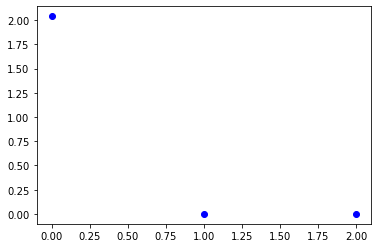

In [ ]:
plt.plot(eigenvals, 'bo')

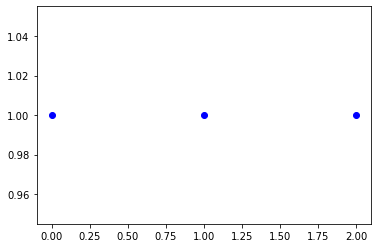

In [ ]:
plt.plot(np.cumsum(eigenvals) / sum(eigenvals), 'bo')



In [ ]:
PC = df1.to_numpy() @ eigenvecs


In [ ]:
PC = PC[:, :]
PC.shape

(50, 2)

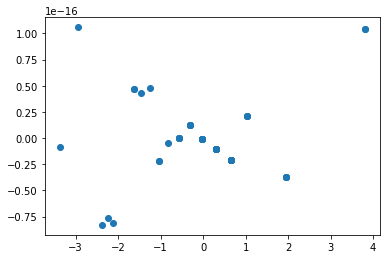

In [ ]:
plt.scatter(PC[:,0], PC[:,1])

[Terug naar boven](#start)

# **NMF**<a name='h7'></a>

[Terug naar boven](#start)

# **Suggestie App**<a name='h8'></a>

Een andere opgave die we hadden was om een eenvoudige app te maken voor het aanbevelen van muziek. Om dit te doen is er gekozen om muziek aan te bevelen op basis van het genre. Om hiermee te beginnen moet het lukken om op basis van het genre een audio bestand af te spelen en bestanden aan te raden. Om dit te doen is de onderstaande code ontwikkelt.

In [ ]:
def speel_lied(genre):
    """
    Speelt een willekeurig nummer van het opgegeven muziekgenre af
    en geeft suggesties voor andere nummers binnen hetzelfde genre.

    Parameters:
    ----------
    genre : str
        Het gewenste muziekgenre.

    Returns:
    ----------
    suggesties : list
        Een lijst met suggesties voor andere nummers binnen hetzelfde genre.
        Als het opgegeven genre niet wordt gevonden, wordt None geretourneerd.
    """
    # Selecteer een willekeurig genre
    genre_songs = labeled[labeled['genre'] == genre]

    # Indien het genre niet is gevonden, geef bericht
    if len(genre_songs) == 0:
        print(f"Geen muziek gevonden voor: {genre}."
              f"Probeer een van deze: {labeled['genre'].unique()}")
        return None

    # Pak een willekeurig nummer
    random_song = genre_songs.sample(1).index[0]

    # Display and play the selected song
    audio = os.path.join('labeled/', random_song)
    display(Audio(filename=audio))
    
    # Return suggestions for the selected genre
    suggesties = genre_songs.sample(5)
    return suggesties.index.tolist()

# Selecteren genre en gebruiken functie
selected_genre = 'pop'
suggesties = speel_lied(selected_genre)

# Printen van suggesties
print(f"\nSuggesties voor {selected_genre} genre:")
print(suggesties)


Suggesties voor pop genre:
['m00513.wav', 'm00041.wav', 'm00421.wav', 'm00676.wav', 'm00773.wav']


Nu dit is gelukt, gaan we ons leven wat lastiger maken. Om te zorgen dat er een handmatig gewisseld kan worden tussen genres en nummers zijn hiervoor knoppen aangemaakt met behulp van de ipywidgets libary.

In [ ]:
def speel_r_lied(genre):
    """
    Speelt een willekeurig nummer van het opgegeven muziekgenre af
    en geeft suggesties voor andere nummers binnen hetzelfde genre.

    Parameters:
    ----------
    genre : str
        Het gewenste muziekgenre.

    Returns:
    ----------
    None
    """
    # Selecteer een willekeurig genre
    genre_songs = labeled[labeled['genre'] == genre]

    # Indien het genre niet is gevonden, geef bericht
    if len(genre_songs) == 0:
        print(f"Geen muziek gevonden voor: {genre}."
              f"Probeer een van deze: {labeled['genre'].unique()}")
        return None

    # Pak een willekeurig nummer
    random_song = genre_songs.sample(1).index[0]

    # Toon bestandsnaam en genre
    with output_area:
        clear_output(wait=True)
        display(HTML(f"<h1>--Genre: {genre}--</h1><h3>{random_song}</h3>"))

        # Tonen en speelbaar maken lied
        audio = os.path.join('labeled/', random_song)
        display(Audio(filename=audio))

    # Plaats suggesties voor het genre
    suggesties = genre_songs.sample(5)
    with output_area:
        print(f"\nSuggesties voor {genre} genre:")
        suggesties_knop = [widgets.Button(description=song, layout=widgets.Layout(width='100%')) for song in suggesties.index]
        for button in suggesties_knop:
            button.on_click(suggestie_knop)
        display(*suggesties_knop)

def suggestie_knop(button):
    """
    Zorgt voor de suggestie knoppen

    Parameters:
    ----------
    button : widgets.Button
        De button voor de suggestie

    Returns:
    ----------
    None
    """
    with output_area:
        speel_g_lied(button.description)

def speel_g_lied(song):
    """
    Afspelen van geselecteerd lied

    Parameters:
    ----------
    song : str
        het lied

    Returns:
    ----------
    None
    """
    # Tonen bestandnaam en genre
    with output_area:
        clear_output(wait=True)
        display(HTML(f"<h1>--Genre: {genre}--</h1><h3>{song}</h3>"))

        # Tonen en afspeelbaar maken lied
        audio = os.path.join('labeled/', song)
        display(Audio(filename=audio))

    # Verversen van suggesties
    suggesties = labeled[labeled['genre'] == genre].sample(5)
    with output_area:
        print(f"\nSuggesties voor {genre} genre:")
        suggesties_knop = [widgets.Button(description=song, layout=widgets.Layout(width='100%')) for song in suggesties.index]
        for button in suggesties_knop:
            button.on_click(suggestie_knop)
        display(*suggesties_knop)

def genre_knop(button):
    """
    Zorgt voor het handelen van de genre knoppen

    Parameters:
    ----------
    button : widgets.Button
        De button voor het genre

    Returns:
    ----------
    None
    """
    with output_area:
        global genre
        genre = button.description
        speel_r_lied(genre)

# Ophalen van genres
genres = labeled['genre'].unique()

# Knop maken voor elk genre
genre_knoppen = [widgets.Button(description=genre) for genre in genres]

# Attach the callback function to button clicks
for button in genre_knoppen:
    button.on_click(genre_knop)

# Maak output area voor lied en suggesties
output_area = widgets.Output()

# Random button
random_button = widgets.Button(description="Random Pick")
random_button.on_click(lambda _: speel_r_lied(random.choice(genres)))

# Tonen resultaat
buttons_box = widgets.HBox(genre_knoppen)
display(buttons_box, output_area, random_button)

Output()

Button(description='Random Pick', style=ButtonStyle())

Nu dit is gemaakt kunnen we deze praktijken verder verbeteren en een volledige class maken die functioneert als een app. Deze app heeft als input een dataset, een genre kolom en een directory nodig om te kunnen werken.

In [114]:
class TuneTips:
    """
    Een class die een app opstart. Deze app kan muziekfragmenten
    afspelen en muziek aanraden op basis van genres.
    """
    def __init__(self, root, dataframe, genre_column, directory):
        """
        Initialisatie van de MusicPlayerApp.

        Parameters:
        ----------
        root : Tk
            Het hoofdvenster van de applicatie.

        dataframe : pandas.DataFrame
            Het DataFrame met informatie over de nummers.

        genre_column : str
            De kolom in het DataFrame die het genre van de nummers bevat.

        directory : str
            Het pad naar de map met de muziekbestanden.
        """
        # Aanmaken venster
        self.root = root
        self.root.title("Tune Tips - Music Advisor (BETA-EDITION)")

        # Initialiseren van mixer
        mixer.init()

        # Gebruiken van doorgegeven df, kolom en dir
        self.labeled = dataframe
        self.genre_column = genre_column
        self.directory = directory

        # Ophalen genres in de genre kolom
        self.available_genres = self.labeled[self.genre_column].unique()

        # Aanmaken van genre knoppen
        self.genre_buttons = [ttk.Button(root,
                                         text=genre,
                                         command=lambda g=genre: self.play_random_song(g)
                                         ) for genre in self.available_genres]
        
        # Aanmaken genre label
        self.genre_label = ttk.Label(root, text="Genres:")
        self.genre_label.grid(row=7, column=3, columnspan=2, sticky="w")

        # Genre knoppen plaatsen
        for i, button in enumerate(self.genre_buttons):
            button.grid(row=8 + i, column=3, sticky="nsew")

        # Maken display window voor tekst
        self.d_window = tk.Text(root, height=12, width=100)
        self.d_window.grid(row=1, column=3, rowspan=6, columnspan=4)
        self.d_window.delete(1.0, tk.END)
        self.d_window.tag_configure("big", font=('Helvetica', 42), justify='center')
        self.d_window.insert(tk.END, f"Kies een genre of klik op\nRandom Song", "big")
        self.d_window.yview(tk.MOVETO, 0.0)
        self.d_window.config(state=tk.DISABLED)

        # Aanmaken suggesties label
        self.suggestions_label = ttk.Label(root, text="Song Suggestions:")
        self.suggestions_label.grid(row=7, column=4, columnspan=2, sticky="w")

        # Aanmaken en plaatsten suggestie knoppen
        self.suggestion_buttons = [ttk.Button(root,
                                              text="",
                                              command=lambda i=i: self.play_selected_song(i),
                                              width=18
                                              ) for i in range(10)]
        
        for i, button in enumerate(self.suggestion_buttons):
            button.grid(row=8 + i, column=4, sticky="w")

        # Volume control
        self.volume_label = ttk.Label(root, text="Volume:")
        self.volume_scale = ttk.Scale(root, from_=0, to=100,
                                      orient=tk.HORIZONTAL,
                                      command=self.set_volume,
                                      length=400)


        self.volume_label.grid(row=9, column=5, sticky="e")
        self.volume_scale.grid(row=9, column=6, sticky="w")
        self.volume_scale.set(50)

        # Play/Pause knop
        self.playing = False
        self.play_pause_button = ttk.Button(root, text="Play",
                                            command=self.play_pause_music)
        
        self.play_pause_button.grid(row=10, column=5,
                                    rowspan=2, columnspan=1, sticky="ew")

        # Restart knop
        self.restart_button = ttk.Button(root, text="Restart",
                                         command=self.restart_music)
        
        self.restart_button.grid(row=10, column=6,
                                 rowspan=2, columnspan=1, sticky="ew")

        # Random Song knop
        self.random_number = ttk.Button(root, text="Random Song",
                                        command=self.random_number)
        
        self.random_number.grid(row=11, column=5,
                                rowspan=2, columnspan=2, sticky="ew")

        # Voortgangs display
        self.progress_label = ttk.Label(root, text="Voortgang:")
        self.progress_var = tk.DoubleVar()
        self.progress_bar = ttk.Progressbar(root, orient=tk.HORIZONTAL,
                                            mode='determinate',
                                            variable=self.progress_var,
                                            length=400)
        
        self.progress_label.grid(row=8, column=5, sticky="e")
        self.progress_bar.grid(row=8, column=6, sticky="w")

        # Updaten elke 100 ms
        self.root.after(100, self.update_progress)

    def update_suggestions(self, genre):
        """
        Update de suggestieknoppen op
        basis van het geselecteerde genre.

        Parameters:
        ----------
        genre : str
            Het geselecteerde genre.
        """
        # Ophalen genre en huidig nummer
        genre_songs = self.labeled[self.labeled[self.genre_column] == genre]
        random_song = self.current_song
        self.current_genre = genre

        # Geven van suggesties op basis van genre
        suggestions = self.get_unique_suggestions(genre_songs, random_song, 10)
        for i, song in enumerate(suggestions):
            self.suggestion_buttons[i].config(text=song)

    def play_random_song(self, genre):
        """
        Speel een willekeurig nummer af van het opgegeven genre.

        Parameters:
        ----------
        genre : str
            Het genre van de nummers om uit te kiezen.
        """
        # Indien er muziek speelt, update alleen de buttons
        if self.playing:
            self.update_suggestions(genre)
            return
        
        # Ophalen genres en muziek
        genre_songs = self.labeled[self.labeled[self.genre_column] == genre]
        random_song = genre_songs.sample(1).index[0]

        # Tonen van bestand en genre
        self.d_window.config(state=tk.NORMAL)
        self.d_window.delete(1.0, tk.END)
        self.d_window.tag_configure("big", font=('Helvetica', 42), justify='center')
        self.d_window.insert(tk.END, f"Currently playing: {random_song}"
                                f"\n--Genre: {genre}--", "big")
        
        self.d_window.yview(tk.MOVETO, 0.0)
        self.d_window.config(state=tk.DISABLED)

        # Opslaan van het genre en nummer
        self.current_genre = genre
        self.current_song = random_song

        # Speel het bestand af
        file_path = os.path.join(self.directory, random_song)
        mixer.music.load(file_path)
        mixer.music.play()

        # Geef suggesties op basis van genre
        suggestions = self.get_unique_suggestions(genre_songs, random_song, 10)
        for i, song in enumerate(suggestions):
            self.suggestion_buttons[i].config(text=song)

        # Zet voortgangsbar aan
        song_length = mixer.Sound(file_path).get_length()
        self.progress_bar["maximum"] = int(song_length)

        # Update status
        self.playing = True
        self.play_pause_button.config(text="Pause")

    def get_unique_suggestions(self, genre_songs, current_song, num_suggestions):
        """
        Genereer unieke suggesties voor het geselecteerde genre.

        Parameters:
        ----------
        genre_songs : pandas.DataFrame
            DataFrame met nummerinformatie van het geselecteerde genre.

        current_song : str
            Het nummer dat momenteel wordt afgespeeld.

        num_suggestions : int
            Het aantal suggesties dat moet worden gegenereerd.

        Returns:
        ----------
        suggestions : list of str
            Een lijst met unieke suggesties.
        """
        # Excludeer huidig nummer
        genre_songs = genre_songs[genre_songs.index != current_song]

        # Haal suggesties op
        suggestions = []
        while len(suggestions) < num_suggestions and not genre_songs.empty:
            song = genre_songs.sample(1).index[0]
            suggestions.append(song)
            genre_songs = genre_songs[genre_songs.index != song]

        return suggestions

    def play_selected_song(self, index):
        """
        Speel het geselecteerde nummer af op
        basis van de index van de suggestieknop.

        Parameters:
        ----------
        index : int
            De index van de suggestieknop.
        """
        # Haal nummer op, op basis van knop
        selected_song = self.suggestion_buttons[index].cget("text")
        file_path = os.path.join(self.directory, selected_song)
        mixer.music.load(file_path)
        mixer.music.play()

        # Updaten display tekst
        self.d_window.config(state=tk.NORMAL)
        self.d_window.delete(1.0, tk.END)
        self.d_window.tag_configure("big", font=('Helvetica', 42), justify='center')
        self.d_window.insert(tk.END, f"Currently playing: {selected_song}"
                             f"\n--Genre: {self.current_genre}--", "big")
        
        self.d_window.yview(tk.MOVETO, 0.0)
        self.d_window.config(state=tk.DISABLED)

        # Opslaan van nummer
        self.current_song = selected_song

        # Update status
        self.playing = True
        self.play_pause_button.config(text="Pause")

    def random_number(self):
        """
        Speel een willekeurig nummer
        af van een willekeurig genre.
        """
        # Kiezen willekeurig genre
        genre = random.choice(self.available_genres)
        self.play_random_song(genre)

    def restart_music(self):
        """
        Herstart het afspelen van het huidige nummer.
        """
        # Indien er muziek speelt
        if self.playing:
            mixer.music.rewind()
            mixer.music.play()
        # Begin opnieuw wanneer op pauze 
        # (zonder code wilde dit niet werken)
        else:
            file_path = os.path.join(self.directory, self.current_song)
            mixer.music.load(file_path)
            mixer.music.play()

        # Updaten status
        self.playing = True
        self.play_pause_button.config(text="Pause")

    def set_volume(self, val):
        """
        Stel het volume in op basis van de opgegeven waarde.

        Parameters:
        ----------
        val : float
            De waarde om het volume in te
            stellen (tussen 0 en 100).
        """
        # Regelen van volumeknop
        volume = float(val) / 100
        mixer.music.set_volume(volume)

    def play_pause_music(self):
        """
        Pauzeer of hervat het afspelen van muziek
        """
        # Als muziek speelt, pauzeer
        if mixer.music.get_busy():
            mixer.music.pause()
            self.play_pause_button.config(text="Play")
        # Zo niet, speel muziek
        else:
            mixer.music.unpause()
            self.play_pause_button.config(text="Pause")

        # Wissel van staat
        self.playing = not self.playing

    def update_progress(self):
        """
        Voortgangsbalk op basis
        van de huidige afspeeltijd.
        """
        # Indien muziek speelt
        if mixer.music.get_busy():
            current_time = mixer.music.get_pos() / 1000
            self.progress_var.set(current_time)
        else:
            # Als muziek klaar is, zet knop op tekst Play
            self.play_pause_button.config(text="Play")
            self.playing = False

        # update elke 100 ms
        self.root.after(100, self.update_progress)


Nu de class is gemaakt kan deze worden aangeroepen. Zodra dit gebeurt opent er een extra window. Deze window bevat knoppen waarop gedrukt kan worden om handelingen uit te voeren binnen de applicatie. De eerste cel is in comments gezet zodat deze niet zal runnen bij run-all. Dit is voornamelijk omdat we liever hebben dat de app ervaren wordt met de geclusterde data.

In [ ]:
# Gebruiken van de app op labeled
# root = tk.Tk()
# app = MusicPlayerApp(root, labeled, 'genre', 'labeled/')
# root.mainloop()

In [115]:
# Gebruiken van de app op unlabeled
root = tk.Tk()
app = TuneTips(root, scdf, 'cluster', 'unlabeled/')
root.mainloop()

[Terug naar boven](#start)

# **Conclusie & Discussie**<a name='h9'></a>

[Terug naar boven](#start)

# **Bronnen**<a name='Bron'></a>

Singh, T. (2021, December 10). MFCC’s Made Easy - Tanveer Singh - medium. Medium.<br>https://medium.com/@tanveer9812/mfccs-made-easy-7ef383006040

Wikipedia contributors. (2023, November 13). Mel-frequency cepstrum. Wikipedia.<br>https://en.wikipedia.org/wiki/Mel-frequency_cepstrum

Discrete Fourier Transform | Brilliant Math & Science Wiki. (n.d.).<br>https://brilliant.org/wiki/discrete-fourier-transform/

spectral_features. (n.d.).<br>https://musicinformationretrieval.com/spectral_features.html

Nam, U. (2001, April 28). Special Area Exam Part II.<br>https://ccrma.stanford.edu/~unjung/AIR/areaExam.pdf

librosa.feature.tonnetz — librosa 0.10.1 documentation. (n.d.).<br>https://librosa.org/doc/main/generated/librosa.feature.tonnetz.html

librosa.feature.spectral_rolloff — librosa 0.10.1 documentation. (n.d.).<br>https://librosa.org/doc/main/generated/librosa.feature.spectral_rolloff.html

[Terug naar boven](#start)